# Import librairies

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# lazy 
from lazypredict.Supervised import LazyClassifier
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin

# search hyperparameters
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# modèles 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

import xgboost as xgb
import shap

# métriques 
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import classification_report,accuracy_score, f1_score, fbeta_score
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, precision_recall_curve

# Rééchantillonage
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from imblearn.under_sampling import RandomUnderSampler

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# sauvegarde model
import pickle

# import des fonctions de modélisations
import  modeling_functions


ModuleNotFoundError: No module named 'modeling_functions'

# Chargement données issues du preprocessing

In [5]:

# jeu de données issues du preprocessing mixte
df_V1 = pd.read_csv("../data_saved/df_final.csv", index_col=["id_Location","id_Date"])

# jeu de données issues du preprocessing successif
df_V2 =  pd.read_csv("../data_saved/data_preprocessed_V2.csv", index_col=["id_Location","id_Date"])
df_V2 = df_V2.drop(columns=["Evaporation", 'Sunshine', 'Cloud9am', 'Cloud3pm'])

# jeu de données issues du preprocessing successif pour Canberra
df_Canberra =  pd.read_csv("../src/data_location_V2/df_Canberra.csv", index_col=["id_Location","id_Date"])

print(df_V1.shape)
print(df_V1.columns)
print(df_V2.shape)
print(df_V2.columns)
print(df_Canberra.shape)
print(df_Canberra.columns)

(135600, 42)
Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow', 'WindGustDir_cos', 'WindGustDir_sin', 'WindDir9am_cos',
       'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin', 'Month_cos',
       'Month_sin', 'Season_cos', 'Season_sin', 'Climate_Desert',
       'Climate_Grassland', 'Climate_Subtropical', 'Climate_Temperate',
       'Climate_Tropical', 'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010',
       'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015',
       'Year_2016', 'Year_2017'],
      dtype='object')
(142193, 46)
Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow', 'sin_lat', 'cos

In [6]:
print(df_V1.dropna().shape)
print(df_V2.dropna().shape)

(135600, 42)
(136222, 46)


# Séparation en train et test 

In [7]:
# function pour l'intégrer dans un pipeline et pouvoir l'utiliser sur des données par location

def separation_train_test(df, sep_method = "classique", col_target = "RainTomorrow"):
    # drop les Nas restants 
    df = df.dropna()
    target = df[col_target]
    feats = df.drop(columns = col_target)

    if sep_method == "classique":
        X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.3, random_state=1234, stratify=target)
    if sep_method == "temporelle":
        df["Date"] = df.index.get_level_values(1).values
        years = pd.to_datetime(df.Date).dt.year
        years.unique()
        years.value_counts(ascending=True)
        Part_data_year = years.value_counts().sort_index().cumsum()/len(years)
        print("Part des données par années ", Part_data_year)
        year_split = Part_data_year.loc[Part_data_year > 0.8].index[0]
        id_train = years[years < year_split].index
        id_test = years[years >= year_split].index
        print("Séparation des données avant et après ", year_split)
        X_train = feats.loc[id_train]
        X_test =  feats.loc[id_test]
        y_train = target.loc[id_train]
        y_test =  target.loc[id_test]

    if 'Date' in X_train.columns:
        X_train = X_train.drop(columns = "Date")
        X_test = X_test.drop(columns = "Date")
    if 'Location' in X_train.columns:
        X_train = X_train.drop(columns = 'Location')
        X_test = X_test.drop(columns = 'Location')

    return X_train, X_test, y_train, y_test

In [8]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = separation_train_test(df_V2, sep_method="classique")
X_train_V1, X_test_V1, y_train_V1, y_test_V1 = separation_train_test(df_V1, sep_method="classique")

In [9]:
X_train_V2t, X_test_V2t, y_train_V2t, y_test_V2t = separation_train_test(df_V2, sep_method="temporelle")
X_train_V1t, X_test_V1t, y_train_V1t, y_test_V1t = separation_train_test(df_V1, sep_method="temporelle")

Part des données par années  Date
2007   0.00
2008   0.02
2009   0.13
2010   0.25
2011   0.35
2012   0.46
2013   0.57
2014   0.70
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015
Part des données par années  Date
2007   0.00
2008   0.02
2009   0.13
2010   0.25
2011   0.35
2012   0.46
2013   0.57
2014   0.70
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015


In [10]:
print(X_train_V1t.shape)
print(X_test_V1t.shape)
print(X_train_V2t.shape)
print(X_test_V2t.shape)

(94452, 39)
(41148, 39)
(94809, 43)
(41413, 43)


# Scaling

In [11]:
# fonction pour scaler, avec chois du scaler

def scaling(X_train, X_test, scaler = MinMaxScaler()):

    scaler = scaler
    # On fit sur Xtrain complet
    scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns = X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns = X_test.columns)
    
    return X_train_scaled, X_test_scaled


In [12]:
X_train_V1t_scaled, X_test_V1t_scaled = scaling(X_train_V1t, X_test_V1t, scaler = MinMaxScaler())
X_train_V2t_scaled, X_test_V2t_scaled = scaling(X_train_V2t, X_test_V2t, scaler = MinMaxScaler())

<Figure size 1000x1000 with 0 Axes>

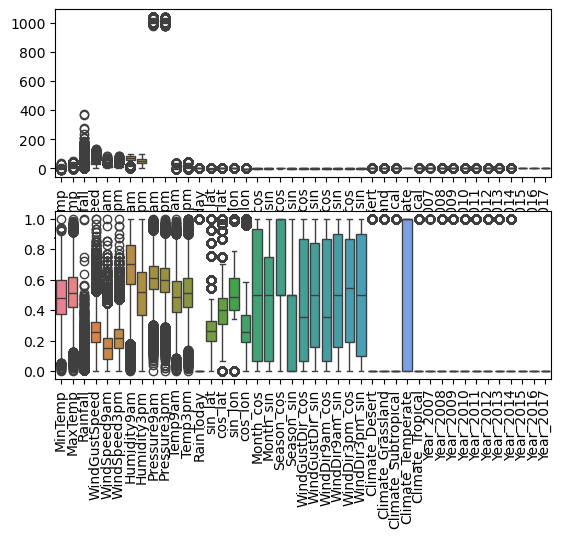

In [13]:
plt.figure(figsize = (10,10))
plt.subplots(ncols=1, nrows=2)
plt.subplot(211)
sns.boxplot(X_train_V2t)
plt.xticks(rotation=90)
plt.subplot(212)
sns.boxplot(X_train_V2t_scaled)
plt.xticks(rotation=90)
plt.show()

# Lazy predict 

In [14]:

removed_classifiers = [
"ClassifierChain",
"ComplementNB",
"GradientBoostingClassifier",
"GaussianProcessClassifier",
"HistGradientBoostingClassifier",
"MLPClassifier",
"LogisticRegressionCV",
"MultiOutputClassifier",
"MultinomialNB",
"OneVsOneClassifier",
"OneVsRestClassifier",
"OutputCodeClassifier",
"RadiusNeighborsClassifier",
"VotingClassifier",
'SVC','LabelPropagation','LabelSpreading','NuSV']

def lazy_results(X_train, X_test, y_train, y_test, removed_classifiers=removed_classifiers):
    classifiers_list = [est for est in all_estimators() if (issubclass(est[1], ClassifierMixin) and (est[0] not in removed_classifiers))]
    # création classifier lazy 
    clf_lazy = LazyClassifier(
        verbose=0, classifiers= classifiers_list,
        ignore_warnings=True, 
        custom_metric=None)

    # fits
    models, predictions = clf_lazy.fit(X_train, X_test, y_train, y_test)
    # sort par f1 score 
    models= models.sort_values("F1 Score", ascending = False)
    models = models.apply(lambda x: round(x, ndigits=2))
    # print models 
    display(models)
    return models, predictions



In [15]:

models_V2t, predictions_V2t = lazy_results(X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t)
models_V1t, predictions_V1t = lazy_results(X_train_V1t_scaled, X_test_V1t_scaled, y_train_V1t, y_test_V1t)

models_V1t.to_csv("../modeling_results/lazy_predict_mixtepreprocessing_temp.csv",  decimal = ",")
models_V2t.to_csv("../modeling_results/lazy_predict_succereprocessing_temp.csv",  decimal = ",")




'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [00:55<00:00,  2.14s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.85,0.72,0.72,0.84,15.74
ExtraTreesClassifier,0.85,0.71,0.71,0.84,10.01
LogisticRegression,0.84,0.71,0.71,0.83,0.38
LinearDiscriminantAnalysis,0.84,0.72,0.72,0.83,0.61
BaggingClassifier,0.84,0.71,0.71,0.83,9.92
CalibratedClassifierCV,0.84,0.71,0.71,0.83,3.88
LinearSVC,0.84,0.71,0.71,0.83,0.80
AdaBoostClassifier,0.84,0.71,0.71,0.83,5.33
SGDClassifier,0.84,0.70,0.70,0.83,0.53


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [00:49<00:00,  1.91s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.85,0.72,0.72,0.84,14.78
ExtraTreesClassifier,0.85,0.71,0.71,0.84,9.85
LinearDiscriminantAnalysis,0.84,0.72,0.72,0.83,0.46
LogisticRegression,0.84,0.72,0.72,0.83,0.27
CalibratedClassifierCV,0.84,0.71,0.71,0.83,2.51
BaggingClassifier,0.84,0.71,0.71,0.83,8.21
LinearSVC,0.84,0.71,0.71,0.83,0.64
AdaBoostClassifier,0.84,0.71,0.71,0.83,4.86
SGDClassifier,0.84,0.71,0.71,0.83,0.41


# modèles simples 

In [42]:
# Choix de 3 modèles 
models_select  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BaggingClassifier': BaggingClassifier(n_estimators = 500, max_samples = 0.5, m
                                           ax_features = 0.5, n_jobs=-1)
}

def fit_models(models_select, X_train,X_test, y_train, y_test, 
               unbalanced = False, save_models_dir = "../saved_models/"): 
      # Dictionnaire pour stocker les résultats
      results = {}
      cm = {}
      fitted_models = {}
      for model_name, model in models_select.items():
            print("Fitting " , model_name)
            model.fit(X_train, y_train)

            # Tester sur les données de test
            y_pred = model.predict(X_test)

            # métriques
            test_accuracy = accuracy_score(y_test, y_pred)
            test_f1_score = f1_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            
            if unbalanced == True :
                 report = classification_report_imbalanced(y_test, y_pred, output_dict=True)
            
            report = pd.DataFrame(report).transpose()
            # Stocker les résultats
            results[model_name] = report
            cm[model_name] = confusion_matrix(y_test, y_pred)
            cm[model_name] = pd.DataFrame(cm[model_name], index = y_train.unique(), columns=y_train.unique())    
            
            # sauvegarde model
            fitted_models[model_name] = model
            with open(save_models_dir + model_name + '.pkl', 'wb') as f:
                  pickle.dump(model, f)
      return results, cm, fitted_models

def print_save_models(models_select, report,  cm,  save_name, dir_name=''):
    # affiche et save les résultats
    for model_name, model in models_select.items():
        print("\n")
        print("Nom du modèle :",model_name)
        print("Rapport de classification :")
        print(report[model_name])
        print("Matrice de confusion :")
        print(cm[model_name])
        report[model_name] = report[model_name].apply(lambda x: round(x,ndigits=2))
        report[model_name].to_csv("../modeling_results/" + dir_name + "/results_" + save_name + "_" + model_name + ".csv", decimal =",")




In [43]:
# Test sur données preprocessed V1

report_V1t, cm_V1t, models_V1t = \
    fit_models(models_select, 
               X_train_V1t_scaled, X_test_V1t_scaled, 
               y_train_V1t, y_test_V1t, 
               save_models_dir="../saved_models/global/base_V1t_")

print_save_models(models_select, report_V1t, cm_V1t, save_name="base_V1t")



Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.85    0.97      0.91 32167.00
1.0                0.79    0.36      0.50  8981.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.82    0.67      0.70 41148.00
weighted avg       0.83    0.84      0.82 41148.00
Matrice de confusion :
       0.00  1.00
0.00  31314   853
1.00   5713  3268


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.95      0.91 32167.00
1.0                0.73    0.50      0.60  8981.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.80    0.73      0.75 41148.00
weighted avg       0.84    0.85      0.84 41148.00
Matrice de confusion :
       0.00  1.00
0.00  30542  1625
1.00   4480  4501


Nom du modè

In [41]:
# Test sur données preprocessed V2

report_V2t, cm_V2t, models_V2t = \
    fit_models(models_select, X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t)

print_save_models(models_select, report_V2t, cm_V2t , save_name="base_V2t")



Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.94    0.66      0.78 32235.00
1.0                0.42    0.86      0.56  9178.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.68    0.76      0.67 41413.00
weighted avg       0.83    0.71      0.73 41413.00
Matrice de confusion :
       0.00   1.00
0.00  21319  10916
1.00   1274   7904


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.86    0.96      0.91 32235.00
1.0                0.78    0.46      0.58  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.71      0.75 41413.00
weighted avg       0.84    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  31042  1193
1.00   4938  4240


Nom du m

# Rééchantillonage

In [19]:

def resample(X_train, y_train, resampler = SMOTE()):
    
    print('Classes échantillon initial :', dict(pd.Series(y_train).value_counts()))
    resampler = resampler
    X_sm, y_sm = resampler.fit_resample(X_train, y_train)
    print('Classes échantillon SMOTE :', dict(pd.Series(y_sm.value_counts())))
    return X_sm, y_sm

In [20]:
# oversampling et fit sur données preprocessed V2


X_train_rs_V2t, y_train_rs_V2t = resample(X_train_V2t,  y_train_V2t, resampler = SMOTE())
X_train_rs_V2t, X_test_V2t_scaled = scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

report_V2t, cm_V2t, models_V2t = \
    fit_models(models_select, X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t)

print_save_models(models_select, report_V2t, cm_V2t , save_name="rssmote_V2t")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon SMOTE : {0.0: 73484, 1.0: 73484}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.00    0.00      0.00 32235.00
1.0                0.22    1.00      0.36  9178.00
accuracy           0.22    0.22      0.22     0.22
macro avg          0.11    0.50      0.18 41413.00
weighted avg       0.05    0.22      0.08 41413.00
Matrice de confusion :
      0.00   1.00
0.00     0  32235
1.00     0   9178


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.90    0.90      0.90 32235.00
1.0                0.64    0.64      0.64  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.77      0.77 41413.00
weighted avg       0.84    0.84  

In [21]:
# undersampling et fit sur données preprocessed V2
X_train_rs_V2t, y_train_rs_V2t = resample(X_train_V2t,  y_train_V2t, resampler = RandomUnderSampler())
X_train_rs_V2t, X_test_V2t_scaled = scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

report_V2t, cm_V2t, models_V2t = \
    fit_models(models_select, X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t)

print_save_models(models_select, report_V2t, cm_V2t , save_name="rsunder_V2t")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon SMOTE : {0.0: 21325, 1.0: 21325}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.94    0.71      0.80 32235.00
1.0                0.45    0.83      0.58  9178.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.69    0.77      0.69 41413.00
weighted avg       0.83    0.73      0.75 41413.00
Matrice de confusion :
       0.00  1.00
0.00  22773  9462
1.00   1576  7602


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 32235.00
1.0                0.54    0.77      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.73    0.79      0.75 41413.00
weighted avg       0.84    0.81  

In [22]:
# combinaison over et under samling et fit sur données preprocessed V2
X_train_rs_V2t, y_train_rs_V2t = resample(X_train_V2t,  y_train_V2t, resampler = SMOTETomek())
X_train_rs_V2t, X_test_V2t_scaled = scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

report_V2t, cm_V2t, models_V2t = \
    fit_models(models_select, X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t)

print_save_models(models_select, report_V2t, cm_V2t , save_name="rssmotetomek_V2t")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon SMOTE : {0.0: 73218, 1.0: 73218}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.00    0.00      0.00 32235.00
1.0                0.22    1.00      0.36  9178.00
accuracy           0.22    0.22      0.22     0.22
macro avg          0.11    0.50      0.18 41413.00
weighted avg       0.05    0.22      0.08 41413.00
Matrice de confusion :
      0.00   1.00
0.00     0  32235
1.00     0   9178


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.90    0.90      0.90 32235.00
1.0                0.64    0.63      0.64  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.77      0.77 41413.00
weighted avg       0.84    0.84  

In [23]:
# test Balanced RandomForest et Bagging sur V2t

models_select_balanced = {
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, max_samples = 0.5, max_features = 0.5, n_jobs=-1)
}

report_V2t, cm_V2t, models_V2t = \
    fit_models(models_select_balanced, X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
               )

print_save_models(models_select_balanced, report_V2t, cm_V2t , save_name="balanced_V2t")


Fitting  BalancedRandomForestClassifier
Fitting  BalancedBaggingClassifier


Nom du modèle : BalancedRandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 32235.00
1.0                0.55    0.76      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.73    0.79      0.75 41413.00
weighted avg       0.84    0.81      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  26391  5844
1.00   2177  7001


Nom du modèle : BalancedBaggingClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.91    0.85      0.88 32235.00
1.0                0.57    0.72      0.64  9178.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.74    0.78      0.76 41413.00
weighted avg       0.84    0.82      0.83 41413.00
Matrice de confusion :
       0.00  1.00
0.00  27276  4959
1.00   2538  6640


# Optimisation des hyperparamètres

In [25]:
# Dictionnaire pour stocker les résultats (njobs -1)
results_search = {}

def compare_search_methods(model_name, 
                           model, 
                           param_grid, 
                           X_train,  X_test, y_train, y_test,
                           scoring='average_precision'):
    # search_methods = {
    #     'GridSearchCV': GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1),
    #     'RandomizedSearchCV': RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1),
    #     'BayesSearchCV': BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
    # }
    
    search_methods = {
        'GridSearchCV': GridSearchCV(estimator=model, 
                                     param_grid=param_grid, 
                                     cv=3, 
                                     scoring=scoring, refit = "accuracy",
                                     verbose =4, 
                                     n_jobs = -1,
                                     return_train_score=True),
    }

    results_search[model_name] = {}
    i = 1
    print(model_name)
    for search_name, search in search_methods.items():
        print(search_name)
        # Effectuer la recherche d'hyperparamètres
        search.fit(X_train, y_train)
        
        # Meilleur score et hyperparamètres trouvés
        best_params = search.best_params_
        best_score = search.best_score_
        
        # Tester sur les données de test
        y_pred = search.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1_score = f1_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)

        # Stocker les résultats
        results_search[model_name][search_name] = {
            'best_params': best_params,
            'best_cv_score': best_score,
            'test_accuracy': test_accuracy,
            'test_f1_score': test_f1_score,
            'test_precision' : test_precision,
            'test_recall' : test_recall
        }

    return results_search


In [44]:
# Hyperparamètres à tester pour chaque modèle
param_grids1 = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10], 
                           'solver': ['liblinear', 'lbfgs'],
                           'class_weight': [{0 : 1, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'RandomForestClassifier': {'n_estimators': [50, 100, 200], 
                               'max_depth': [10, 20, 30],
                               'criterion':['gini', 'entropy', 'log_loss'],
                               'class_weight': [{0 : 1, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'BalancedRandomForestClassifier': {'n_estimators': [50, 100, 200], 
                               'max_depth': [10, 20, 30],
                               'criterion':['gini', 'entropy', 'log_loss'],
                               'class_weight': [{0 : 1, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'BaggingClassifier': {'n_estimators': [500, 1000, 2000], 
                           'max_samples' : [0.1, 0.5, 1]},
    'BalancedBaggingClassifier': {'n_estimators': [500, 1000, 2000], 
                           'max_samples' : [0.05, 0.1, 0.2, 0.5]}
}
# Hyperparamètres à tester pour chaque modèle
param_grids2 = {
    'LogisticRegression': {
        'max_iter' : [100,500],
        'C':[0.001, 0.01, 0.1, 1, 10],
        'solver': ['newton-cholesky','newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty':['none', 'elasticnet', 'l1', 'l2'],
        'fit_intercept': [True, False],
        'class_weight': [{0 : 1, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [10, 30, 50],
        'max_features': ['sqrt', None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'class_weight': [{0 : 1, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'BalancedRandomForestClassifier': {
        'n_estimators': [100, 200, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [10, 30, 50],
        'max_features': ['sqrt', None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'class_weight': [{0 : 1, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'BaggingClassifier': {
        'n_estimators': [50, 500, 1000, 2000], 
        'max_samples' : [0.05, 0.1, 0.2, 0.5, 1],
        'max_features': [0.5, 0.8, 0.95, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]},
    'BalancedBaggingClassifier': {
        'n_estimators': [50, 500, 1000, 2000], 
        'max_samples' : [0.05, 0.1, 0.2, 0.5, 1],
        'max_features': [0.5, 0.8, 0.95, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]}
}

In [39]:
models_select

{'LogisticRegression': LogisticRegression(max_iter=500, n_jobs=-1),
 'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
 'BaggingClassifier': BaggingClassifier(max_features=0.5, max_samples=0.5, n_estimators=500,
                   n_jobs=-1)}

In [45]:
# tuning LR basique sans rééchantillonage 
model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)

results_search = {}
compare_search_methods(model_name, model, 
                       param_grids2[model_name],  
                       X_train_V2t_scaled, X_test_V2t_scaled,
                       y_train_V2t,  y_test_V2t,
                       scoring="average_precision")

results_search

LogisticRegression
GridSearchCV
Fitting 3 folds for each of 960 candidates, totalling 2880 fits


{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 0.1,
    'class_weight': {0: 4, 1: 1},
    'fit_intercept': True,
    'max_iter': 500,
    'penalty': 'l1',
    'solver': 'saga'},
   'best_cv_score': 0.6689864893709295,
   'test_accuracy': 0.8188974476613624,
   'test_f1_score': 0.3409490333919156,
   'test_precision': 0.8810172570390554,
   'test_recall': 0.2113750272390499}}}

In [46]:
results_save_lr = results_search

print(results_save_lr)

{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 0.1, 'class_weight': {0: 4, 1: 1}, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}, 'best_cv_score': 0.6689864893709295, 'test_accuracy': 0.8188974476613624, 'test_f1_score': 0.3409490333919156, 'test_precision': 0.8810172570390554, 'test_recall': 0.2113750272390499}}}


In [56]:
# fit et sauvegarde (pickle, résultats) le meilleur modèle 
best_params_lr = results_save_lr["LogisticRegression"]["GridSearchCV"]["best_params"]
print(best_params_lr)
lr_best = LogisticRegression(**results_save_lr["LogisticRegression"]["GridSearchCV"]["best_params"],
                             n_jobs=-1)

models_select_best = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1, class_weight =  {0: 4, 1: 1}),
    'LogisticRegression_weighted': LogisticRegression(max_iter = 500, n_jobs=-1),
    'LogisticRegression_tuned': lr_best,
}

report, cm, models = \
    fit_models(models_select_best, X_train_V2t_scaled, 
               X_test_V2t_scaled, y_train_V2t, y_test_V2t,
               save_models_dir = "../saved_models/global/best_V2t")
              

print_save_models(models_select_best, report, cm , save_name="best_V2t")

{'C': 0.1, 'class_weight': {0: 4, 1: 1}, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
Fitting  LogisticRegression
Fitting  LogisticRegression_weighted
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression
Rapport de classification :
                   pre      rec      spe       f1      geo      iba      sup
0.0               0.84     0.97     0.37     0.90     0.60     0.38 32235.00
1.0               0.80     0.37     0.97     0.51     0.60     0.34  9178.00
avg_pre           0.83     0.83     0.83     0.83     0.83     0.83     0.83
avg_rec           0.84     0.84     0.84     0.84     0.84     0.84     0.84
avg_spe           0.51     0.51     0.51     0.51     0.51     0.51     0.51
avg_f1            0.82     0.82     0.82     0.82     0.82     0.82     0.82
avg_geo           0.60     0.60     0.60     0.60     0.60     0.60     0.60
avg_iba           0.37     0.37     0.37     0.37     0.37     0.37     0.37
total_support 41413.00 4141

In [53]:
# tuning LR avec smotek et fit sur données preprocessed V2 et scoring spécifique

f2_score = make_scorer(fbeta_score, beta=0.5, pos_label=1)
scoring = {"f2_score" : f2_score, 
           "accuracy" : make_scorer(accuracy_score)}


model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)

from sklearn.metrics import make_scorer, fbeta_score

X_train_rs_V2t, y_train_rs_V2t = resample(X_train_V2t,  y_train_V2t, resampler = SMOTETomek())
X_train_rs_V2t, X_test_V2t_scaled = scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

results_search = {}
compare_search_methods(model_name, model, 
                       param_grids2[model_name],  
                       X_train_rs_V2t, X_test_V2t_scaled,
                       y_train_rs_V2t,  y_test_V2t,
                       scoring=scoring )


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon SMOTE : {0.0: 73262, 1.0: 73262}
LogisticRegression
GridSearchCV
Fitting 3 folds for each of 960 candidates, totalling 2880 fits


{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 0.01,
    'class_weight': {0: 1, 1: 1},
    'fit_intercept': True,
    'max_iter': 100,
    'penalty': 'l1',
    'solver': 'saga'},
   'best_cv_score': 0.7661207933345672,
   'test_accuracy': 0.22777871682804918,
   'test_f1_score': 0.3646694214876033,
   'test_precision': 0.2229943145925458,
   'test_recall': 1.0}}}

In [54]:
results_save_lr_rs =  results_search

print(results_save_lr_rs)

{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 0.01, 'class_weight': {0: 1, 1: 1}, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}, 'best_cv_score': 0.7661207933345672, 'test_accuracy': 0.22777871682804918, 'test_f1_score': 0.3646694214876033, 'test_precision': 0.2229943145925458, 'test_recall': 1.0}}}


In [57]:

# fit et sauvegarde (pickle, résultats) le meilleur modèle 
best_params_lr_rs = results_save_lr_rs["LogisticRegression"]["GridSearchCV"]["best_params"]
print(best_params_lr_rs)
lr_rs_best = LogisticRegression(**results_save_lr_rs["LogisticRegression"]["GridSearchCV"]["best_params"],
                             n_jobs=-1)


models_select_best = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'LogisticRegression_weighted': LogisticRegression(max_iter = 500, n_jobs=-1),
    'LogisticRegression_tuned': lr_rs_best
}

report, cm, models = \
    fit_models(models_select_best, 
               X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t,
               save_models_dir = "../saved_models/global/best_rs_V2t",
               unbalanced=True) 

print_save_models(models_select_best, report, cm , save_name="best_rs_V2t")


{'C': 0.01, 'class_weight': {0: 1, 1: 1}, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Fitting  LogisticRegression
Fitting  LogisticRegression_weighted
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression
Rapport de classification :
                   pre      rec      spe       f1      geo      iba      sup
0.0               0.00     0.00     1.00     0.00     0.00     0.00 32235.00
1.0               0.22     1.00     0.00     0.36     0.00     0.00  9178.00
avg_pre           0.05     0.05     0.05     0.05     0.05     0.05     0.05
avg_rec           0.22     0.22     0.22     0.22     0.22     0.22     0.22
avg_spe           0.78     0.78     0.78     0.78     0.78     0.78     0.78
avg_f1            0.08     0.08     0.08     0.08     0.08     0.08     0.08
avg_geo           0.00     0.00     0.00     0.00     0.00     0.00     0.00
avg_iba           0.00     0.00     0.00     0.00     0.00     0.00     0.00
total_support 41413.00 414

(146438, 43)

In [132]:
# tuning BalancedRandomForest 
model_name = 'BalancedRandomForestClassifier'
model = BalancedRandomForestClassifier(n_jobs=-1)
f2_score = make_scorer(fbeta_score, beta=0.5, pos_label=1)
scoring = {"f2_score" : f2_score, 
           "accuracy" : make_scorer(accuracy_score)}
scoring = "accuracy"
scoring = "average_precision"

results_search = {}
compare_search_methods(model_name, model, 
                       param_grids1[model_name],  
                       X_train_V2t_scaled, X_test_V2t_scaled,
                       y_train_V2t,  y_test_V2t,
                       scoring=scoring)

results_search

BalancedRandomForestClassifier
GridSearchCV
Fitting 3 folds for each of 27 candidates, totalling 81 fits


{'BalancedRandomForestClassifier': {'GridSearchCV': {'best_params': {'criterion': 'log_loss',
    'max_depth': 10,
    'n_estimators': 200},
   'best_cv_score': 0.663324103656814,
   'test_accuracy': 0.801753072706638,
   'test_f1_score': 0.6252852578731173,
   'test_precision': 0.538014451775055,
   'test_recall': 0.7463499673131401}}}

In [133]:
results_save_brf =  results_search

print(results_save_brf )

{'BalancedRandomForestClassifier': {'GridSearchCV': {'best_params': {'criterion': 'log_loss', 'max_depth': 10, 'n_estimators': 200}, 'best_cv_score': 0.663324103656814, 'test_accuracy': 0.801753072706638, 'test_f1_score': 0.6252852578731173, 'test_precision': 0.538014451775055, 'test_recall': 0.7463499673131401}}}


In [138]:
# fit et sauvegarde (pickle, résultats) le meilleur modèle
model_name = 'BalancedRandomForestClassifier' 
best_params_brf  = results_save_brf[model_name]["GridSearchCV"]["best_params"]
print(best_params_brf )
brf_best = BalancedRandomForestClassifier(**results_save_brf[model_name]["GridSearchCV"]["best_params"],
                             n_jobs=-1)


models_select_best = {
    'brf_tuned' : brf_best,
    'brf': BalancedRandomForestClassifier(n_jobs=-1),
    'rf' : RandomForestClassifier(n_jobs=-1)
}

report, cm, models = \
    fit_models(models_select_best, X_train_V2t_scaled, 
               X_test_V2t_scaled, y_train_V2t, y_test_V2t,
               save_models_dir = "../saved_models/global/best_V2t_") 

print_save_models(models_select_best, report, cm , save_name="best_V2t_")

{'criterion': 'log_loss', 'max_depth': 10, 'n_estimators': 200}
Fitting  brf_tuned
Fitting  brf
Fitting  rf


Nom du modèle : brf_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.86 32235.00
1.0                0.54    0.75      0.62  9178.00
accuracy           0.80    0.80      0.80     0.80
macro avg          0.73    0.78      0.74 41413.00
weighted avg       0.83    0.80      0.81 41413.00
Matrice de confusion :
       0.00  1.00
0.00  26332  5903
1.00   2333  6845


Nom du modèle : brf
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.93    0.82      0.87 32235.00
1.0                0.55    0.77      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.74    0.79      0.75 41413.00
weighted avg       0.84    0.81      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  26431  5804
1.00   2143  7035


Nom du modèle : rf

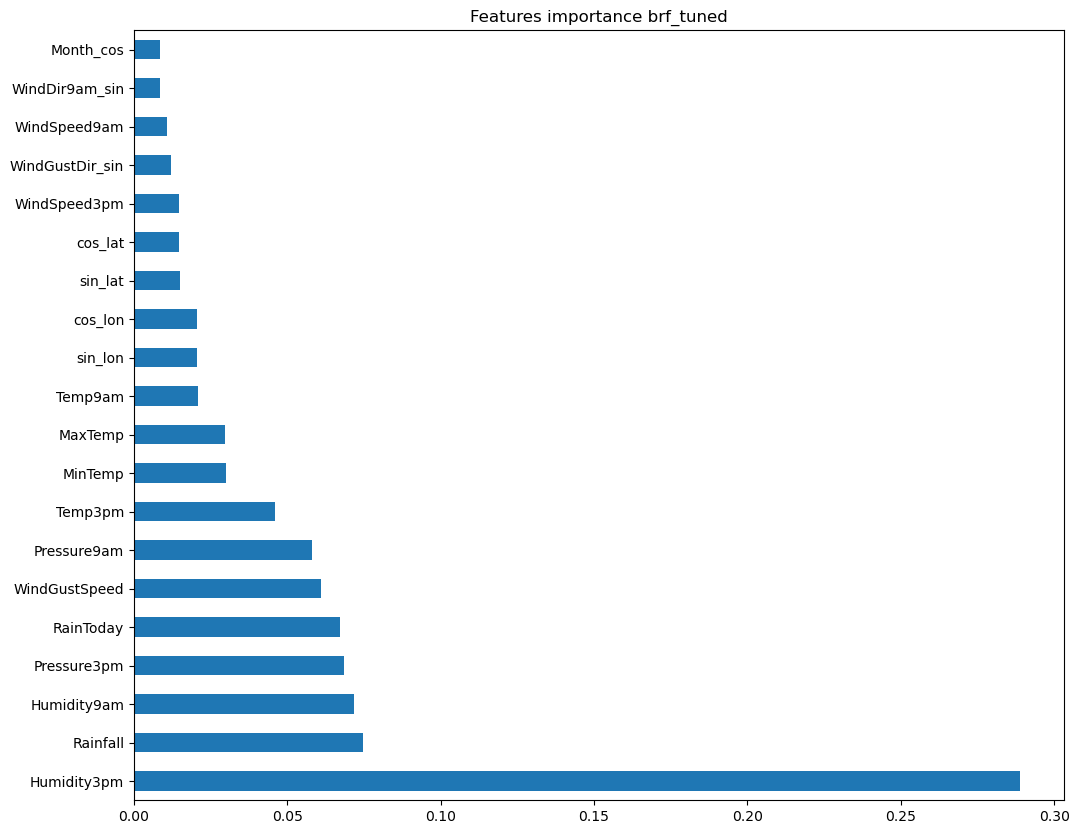

In [141]:
# Graph des Features importances pour le RandomForest

model_name = "brf_tuned" 
model_dir = "../saved_models/global/best_V2t_" + model_name
with open(model_dir + '.pkl', 'rb') as f:
    model = pickle.load(f)

# features importances 
feat_importances = pd.Series(
    model.feature_importances_, index=X_train_V2t_scaled.columns)
fig = plt.figure(figsize = (12,10))
feat_importances.nlargest(20).plot(kind='barh');
plt.title("Features importance " + model_name)

graph_dir = "../modeling_results/best_V2t_" +  model_name
fig.savefig(graph_dir + ".png")

# Modèle par location

In [27]:

# model par location
select_location = "Canberra"
# df_location = list()

df_location =  pd.read_csv("../src/data_location_V2/df_" + select_location + ".csv", index_col=["id_Location","id_Date"])
print(df_location.shape)
print(df_location.columns)

# Choix de 3 modèles 
models_select  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1)
}

X_train, X_test, y_train, y_test = \
    separation_train_test(df_location, 
                          sep_method = "temporelle", 
                          col_target = "RainTomorrow")


X_train_scaled, X_test_scaled = scaling(X_train, X_test, scaler = MinMaxScaler())

# lazy 

models_lazy, predictions_lazy = lazy_results(X_train_scaled, X_test_scaled, y_train, y_test)

# fit basique

report_location, cm_location, models_location = \
    fit_models(models_select, 
               X_train_scaled, X_test_scaled, y_train, y_test,
               save_models_dir="../saved_models/location/" + select_location + "_base_")

print_save_models(models_select, report_location, cm_location, 
                  dir_name = "location",
                  save_name="base_"+ select_location)




(2601, 38)
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month_cos', 'Month_sin',
       'Season_cos', 'Season_sin', 'WindGustDir_cos', 'WindGustDir_sin',
       'WindDir9am_cos', 'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin',
       'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011',
       'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016',
       'Year_2017'],
      dtype='object')
Part des données par années  Date
2007   0.02
2008   0.16
2009   0.26
2010   0.38
2011   0.50
2012   0.62
2013   0.71
2014   0.79
2015   0.87
2016   0.96
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [00:01<00:00, 14.32it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.81,0.73,0.73,0.80,0.02
RandomForestClassifier,0.81,0.73,0.73,0.79,0.35
LogisticRegression,0.80,0.72,0.72,0.79,0.02
ExtraTreesClassifier,0.80,0.71,0.71,0.78,0.22
BaggingClassifier,0.80,0.72,0.72,0.78,0.16
AdaBoostClassifier,0.79,0.72,0.72,0.78,0.17
LinearDiscriminantAnalysis,0.80,0.71,0.71,0.78,0.19
SGDClassifier,0.78,0.75,0.75,0.78,0.02
RidgeClassifier,0.79,0.69,0.69,0.77,0.02


Fitting  LogisticRegression
Fitting  RandomForestClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.78    0.94      0.85   380.00
1.0                0.76    0.43      0.55   173.00
accuracy           0.78    0.78      0.78     0.78
macro avg          0.77    0.69      0.70   553.00
weighted avg       0.78    0.78      0.76   553.00
Matrice de confusion :
      1.00  0.00
1.00   356    24
0.00    98    75


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.81    0.94      0.87   380.00
1.0                0.80    0.52      0.63   173.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.81    0.73      0.75   553.00
weighted avg       0.81    0.81      0.80   553.00
Matrice de confusion :
      1.00  0.00
1.00   358    22
0.00    83    90


In [28]:
# smotetomek et gridsearch sur données preprocessed V2
X_train_rs, y_train_rs = resample(X_train,  y_train, resampler = SMOTETomek())
X_train_rs, X_test_scaled = scaling(X_train_rs, X_test, scaler = MinMaxScaler())

results_search = {}

# Exécuter le search pour chaque modèle
for model_name, model in models_select.items():
    compare_search_methods(model_name, model, 
                       param_grids1[model_name],  
                       X_train_rs, X_test_scaled,
                       y_train_rs,  y_test, 
                       scoring="accuracy")

# Afficher les résultats
for model_name, model_results in results_search.items():
    print(f"Model: {model_name}")
    for search_name, search_results in model_results.items():
        print(f"  {search_name}:")
        print(f"    Best Params: {search_results['best_params']}")
        print(f"    Best CV Score: {search_results['best_cv_score']:2f}")
        print(f"    Test Accuracy: {search_results['test_accuracy']:.2f}")
    print("\n")

Classes échantillon initial : {0.0: 1592, 1.0: 456}
Classes échantillon SMOTE : {1.0: 1579, 0.0: 1579}
LogisticRegression
GridSearchCV
Fitting 3 folds for each of 8 candidates, totalling 24 fits
RandomForestClassifier
GridSearchCV
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Model: LogisticRegression
  GridSearchCV:
    Best Params: {'C': 0.01, 'solver': 'lbfgs'}
    Best CV Score: 0.615582
    Test Accuracy: 0.57


Model: RandomForestClassifier
  GridSearchCV:
    Best Params: {'criterion': 'log_loss', 'max_depth': 30, 'n_estimators': 100}
    Best CV Score: 0.804620
    Test Accuracy: 0.79




In [29]:
# Feat les meilleurs modèle du GridSearch
best_models = {
    'LogisticRegression': 
LogisticRegression(**results_search["LogisticRegression"]["GridSearchCV"]["best_params"],n_jobs=-1),
    'RandomForestClassifier': 
RandomForestClassifier(**results_search["RandomForestClassifier"]["GridSearchCV"]["best_params"],n_jobs=-1)
}

report_location, cm_location, models_location = \
    fit_models(best_models, X_train_rs, X_test_scaled,y_train_rs,  y_test,
               save_models_dir="../saved_models/location/" + select_location + "_best_rs_")

print_save_models(best_models, report_location, cm_location, 
                  dir_name = "location",
                  save_name="base_"+ select_location)


Fitting  LogisticRegression
Fitting  RandomForestClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.41      0.56   380.00
1.0                0.41    0.92      0.57   173.00
accuracy           0.57    0.57      0.57     0.57
macro avg          0.66    0.66      0.57   553.00
weighted avg       0.76    0.57      0.56   553.00
Matrice de confusion :
      1.00  0.00
1.00   154   226
0.00    14   159


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.84    0.86      0.85   380.00
1.0                0.68    0.64      0.66   173.00
accuracy           0.79    0.79      0.79     0.79
macro avg          0.76    0.75      0.75   553.00
weighted avg       0.79    0.79      0.79   553.00
Matrice de confusion :
      1.00  0.00
1.00   328    52
0.00    63   110


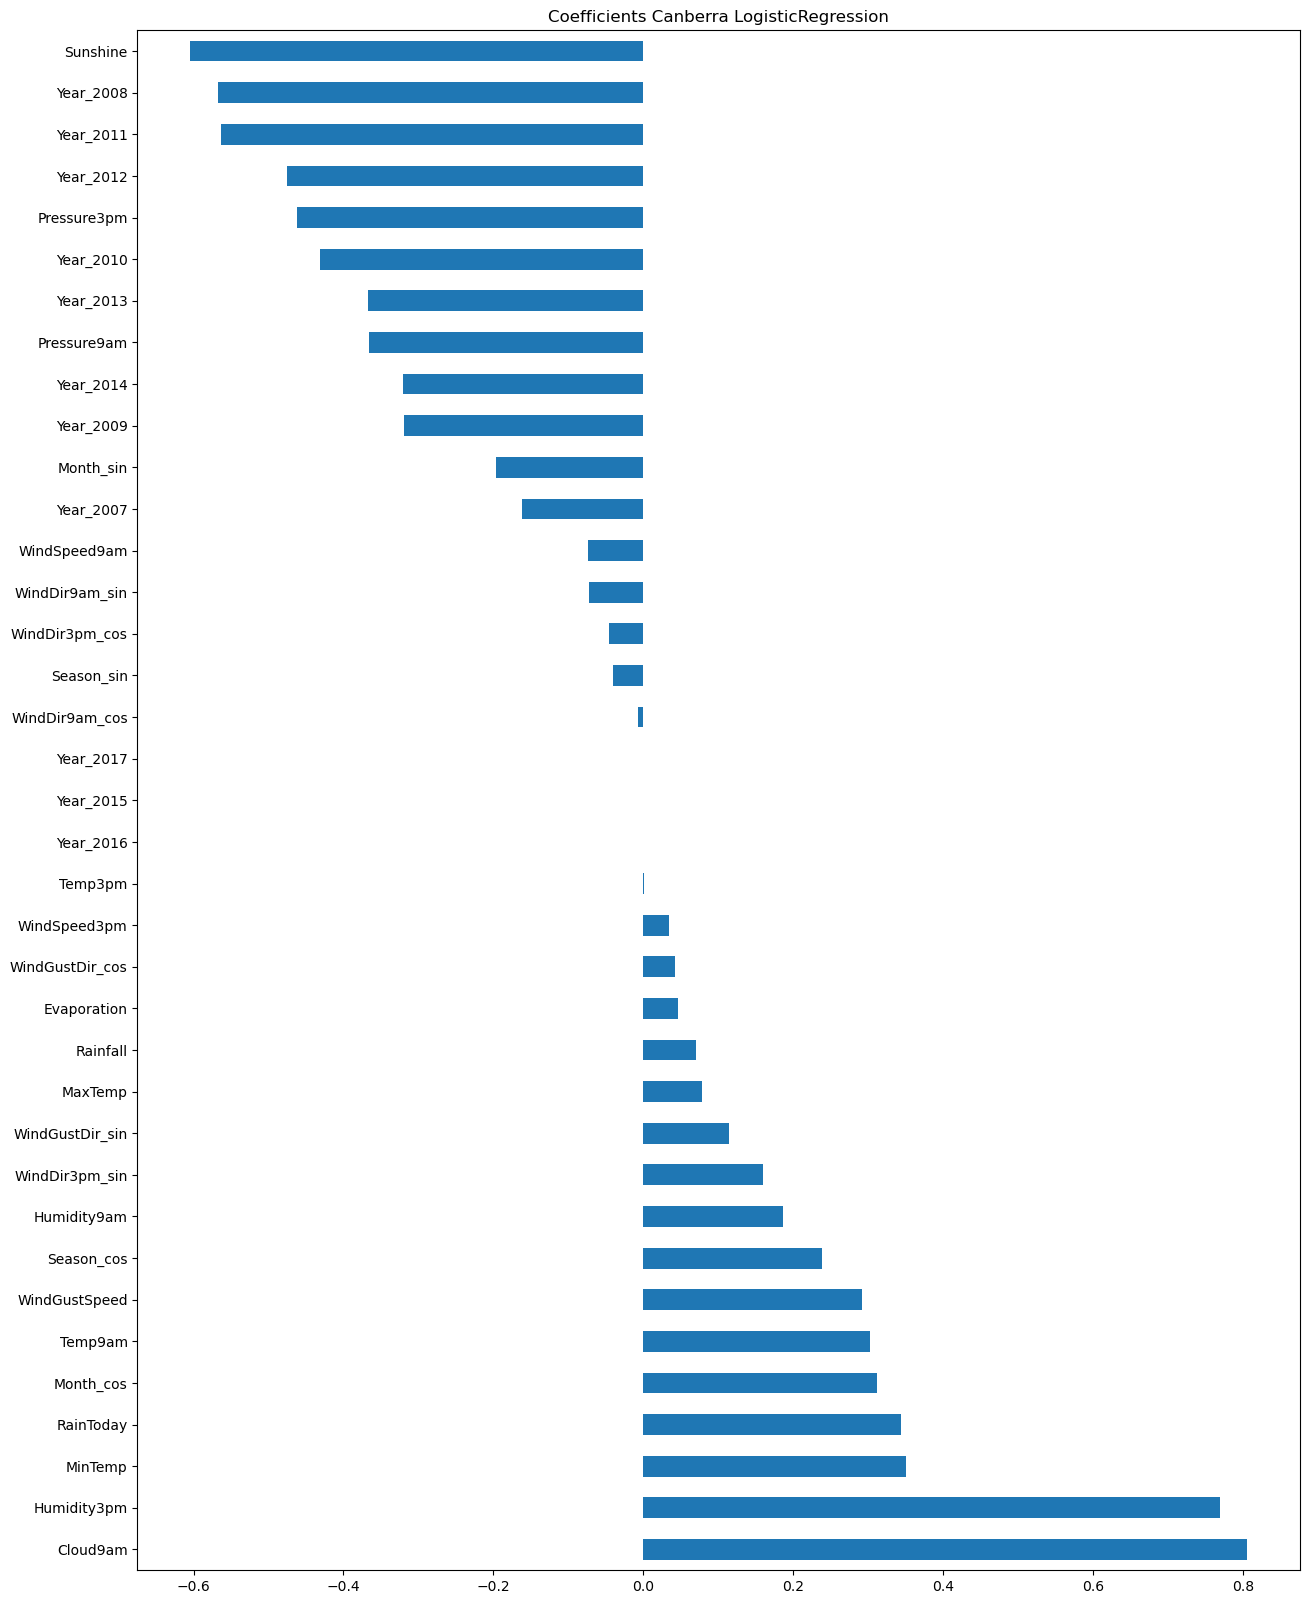

In [30]:
# Graph des coeff de la LogisticRegression

model_name = "LogisticRegression" 
model_dir = "../saved_models/location/" + select_location + "_best_rs_" + model_name
with open(model_dir + '.pkl', 'rb') as f:
    model = pickle.load(f)

model.coef_
pd.Series(model.coef_[0], 
          X_train_rs.columns).sort_values(ascending=False)\
             .plot(kind='barh', figsize=(15,20));
plt.title("Coefficients " + select_location + " " + model_name)

graph_dir = "../modeling_results/location/" + select_location + "_best_rs_" + model_name
plt.savefig(graph_dir + ".png")


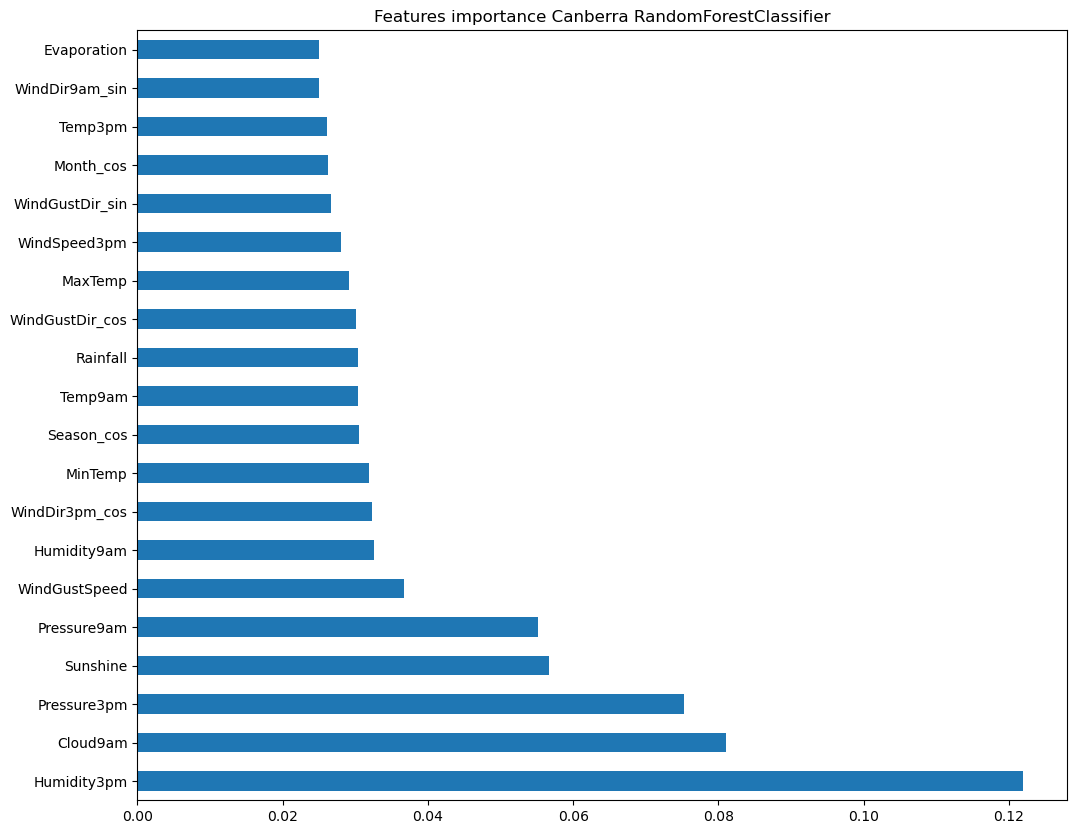

In [31]:
# Graph des Features importances pour le RandomForest

model_name = "RandomForestClassifier" 
model_dir = "../saved_models/location/" + select_location + "_best_rs_" + model_name
with open(model_dir + '.pkl', 'rb') as f:
    model = pickle.load(f)

# features importances 
feat_importances = pd.Series(
    model.feature_importances_, index=X_train_rs.columns)
fig = plt.figure(figsize = (12,10))
feat_importances.nlargest(20).plot(kind='barh');
plt.title("Features importance " + select_location + " " + model_name)

graph_dir = "../modeling_results/location/" + select_location + "_best_rs_" + model_name
fig.savefig(graph_dir + ".png")

# explainer = shap.TreeExplainer(model)
# X = df_location.dropna().drop(columns = ["RainTomorrow"])

# shap_values = explainer.shap_values(X )
# print(shap_values)

# shap.summary_plot(shap_values,X ,plot_type='bar')


# Tentative fonction globale


In [32]:
# model par location
select_location = "Canberra"
# df_location = list()

# Choix des modèles (fixe pour l'instant) 
models_select  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1)
}

df_location =  pd.read_csv("../src/data_location_V2/df_" + select_location + ".csv", index_col=["id_Location","id_Date"])

def modeling_location(select_location, df_location, 
                      models_select, 
                      param_grids, scoring = "accuracy",
                      resampler = RandomUnderSampler()) :

    X_train, X_test, y_train, y_test = \
        separation_train_test(df_location, 
                            sep_method = "temporelle", 
                            col_target = "RainTomorrow")


    X_train_scaled, X_test_scaled = scaling(X_train, X_test, scaler = MinMaxScaler())

    # lazy 

    models_lazy, predictions_lazy = lazy_results(X_train_scaled, X_test_scaled, y_train, y_test)

    # fit basique

    report_location, cm_location, models_location = \
        fit_models(models_select, 
                X_train_scaled, X_test_scaled, y_train, y_test,
                save_models_dir="../saved_models/location/" + select_location + "_base_")

    print_save_models(models_select, report_location, cm_location, 
                    dir_name = "location",
                    save_name="base_"+ select_location)

    # undersampling et gridsearch sur données preprocessed V2
    X_train_rs, y_train_rs = resample(X_train_scaled,  y_train, resampler = resampler)

    results_search = {}

    # Exécuter le search pour chaque modèle
    for model_name, model in models_select.items():
        res = compare_search_methods(model_name, model, 
                        param_grids[model_name],  
                        X_train_rs, X_test_scaled,
                        y_train_rs,  y_test,
                        scoring = scoring)

    print(res)
    results_search = res
    
    # Feat les meilleurs modèle du GridSearch (A PARAMETRER)
    best_models = {
        'LogisticRegression': 
    LogisticRegression(**results_search["LogisticRegression"]["GridSearchCV"]["best_params"],n_jobs=-1),
        'RandomForestClassifier': 
    RandomForestClassifier(**results_search["RandomForestClassifier"]["GridSearchCV"]["best_params"],n_jobs=-1)
    }

    report_location, cm_location, models_location = \
        fit_models(best_models, X_train_rs, X_test_scaled,y_train_rs,  y_test,
                save_models_dir="../saved_models/location/" + select_location + "_best_rs_")

    print_save_models(best_models, report_location, cm_location, 
                    dir_name = "location",
                    save_name="best_"+ select_location)


    # Graph des coeff de la LogisticRegression (A PARAMETRER)

    model_name = "LogisticRegression" 
    model_dir = "../saved_models/location/" + select_location + "_best_rs_" + model_name
    with open(model_dir + '.pkl', 'rb') as f:
        model = pickle.load(f)

    model.coef_
    pd.Series(model.coef_[0], 
            X_train_rs.columns).sort_values(ascending=False)\
                .plot(kind='barh', figsize=(15,20));
    plt.title("Coefficients " + select_location + " " + model_name)

    graph_dir = "../modeling_results/location/" + select_location + "_best_rs_" + model_name
    plt.savefig(graph_dir + ".png")


    # Graph des Features importances pour le RandomForest (A PARAMETRER)

    model_name = "RandomForestClassifier" 
    model_dir = "../saved_models/location/" + select_location + "_best_rs_" + model_name
    with open(model_dir + '.pkl', 'rb') as f:
        model = pickle.load(f)

    # features importances 
    feat_importances = pd.Series(
        model.feature_importances_, index=X_train_rs.columns)
    fig = plt.figure(figsize = (12,10))
    feat_importances.nlargest(20).plot(kind='barh');
    plt.title("Features importance " + select_location + " " + model_name)

    graph_dir = "../modeling_results/location/" + select_location + "_best_rs_" + model_name
    fig.savefig(graph_dir + ".png")

    # explainer = shap.TreeExplainer(model)
    # X = df_location.dropna().drop(columns = ["RainTomorrow"])

    # shap_values = explainer.shap_values(X )
    # print(shap_values)

    # shap.summary_plot(shap_values,X ,plot_type='bar')

    return results_search

Part des données par années  Date
2008   0.10
2009   0.21
2010   0.32
2011   0.42
2012   0.52
2013   0.62
2014   0.73
2015   0.84
2016   0.95
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [00:02<00:00, 11.54it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.84,0.75,0.75,0.83,0.16
RandomForestClassifier,0.84,0.73,0.73,0.82,0.40
LogisticRegression,0.83,0.73,0.73,0.82,0.02
RidgeClassifierCV,0.83,0.73,0.73,0.82,0.18
LinearSVC,0.83,0.73,0.73,0.82,0.02
AdaBoostClassifier,0.83,0.73,0.73,0.82,0.19
RidgeClassifier,0.83,0.73,0.73,0.82,0.02
ExtraTreesClassifier,0.83,0.71,0.71,0.81,0.25
GaussianNB,0.79,0.75,0.75,0.80,0.01


Fitting  LogisticRegression
Fitting  RandomForestClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.85    0.94      0.89   665.00
1.0                0.78    0.55      0.64   242.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.81    0.74      0.77   907.00
weighted avg       0.83    0.84      0.83   907.00
Matrice de confusion :
      1.00  0.00
1.00   627    38
0.00   110   132


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.84    0.96      0.90   665.00
1.0                0.83    0.48      0.61   242.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.83    0.72      0.75   907.00
weighted avg       0.83    0.83      0.82   907.00
Matrice de confusion :
      1.00  0.00
1.00   641    24
0.00   126   116
Classes échantillon initial : {0.0: 1807, 1.0:

{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 0.01,
    'solver': 'liblinear'},
   'best_cv_score': 0.702516962197595,
   'test_accuracy': 0.7816979051819184,
   'test_f1_score': 0.6550522648083623,
   'test_precision': 0.5662650602409639,
   'test_recall': 0.7768595041322314}},
 'RandomForestClassifier': {'GridSearchCV': {'best_params': {'criterion': 'entropy',
    'max_depth': 30,
    'n_estimators': 100},
   'best_cv_score': 0.744980841620789,
   'test_accuracy': 0.8257993384785005,
   'test_f1_score': 0.6425339366515838,
   'test_precision': 0.71,
   'test_recall': 0.5867768595041323}}}

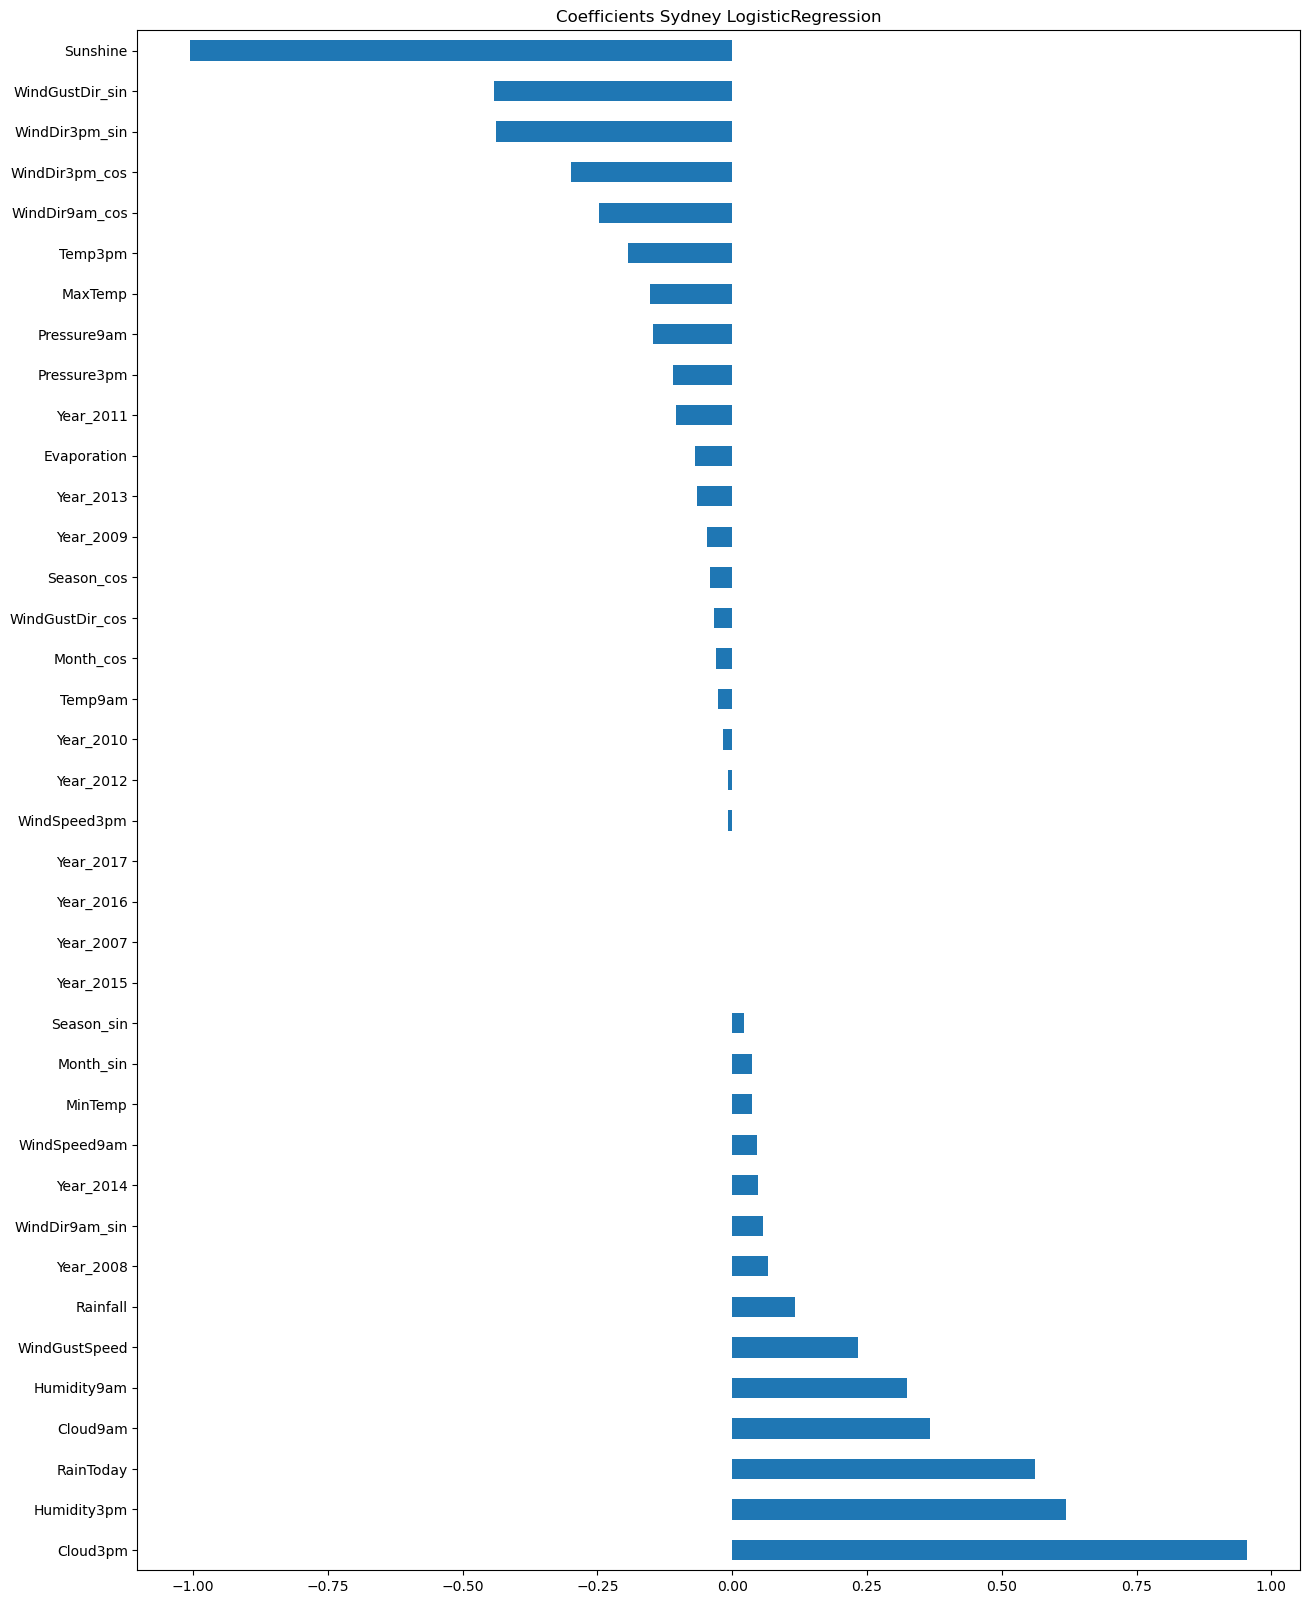

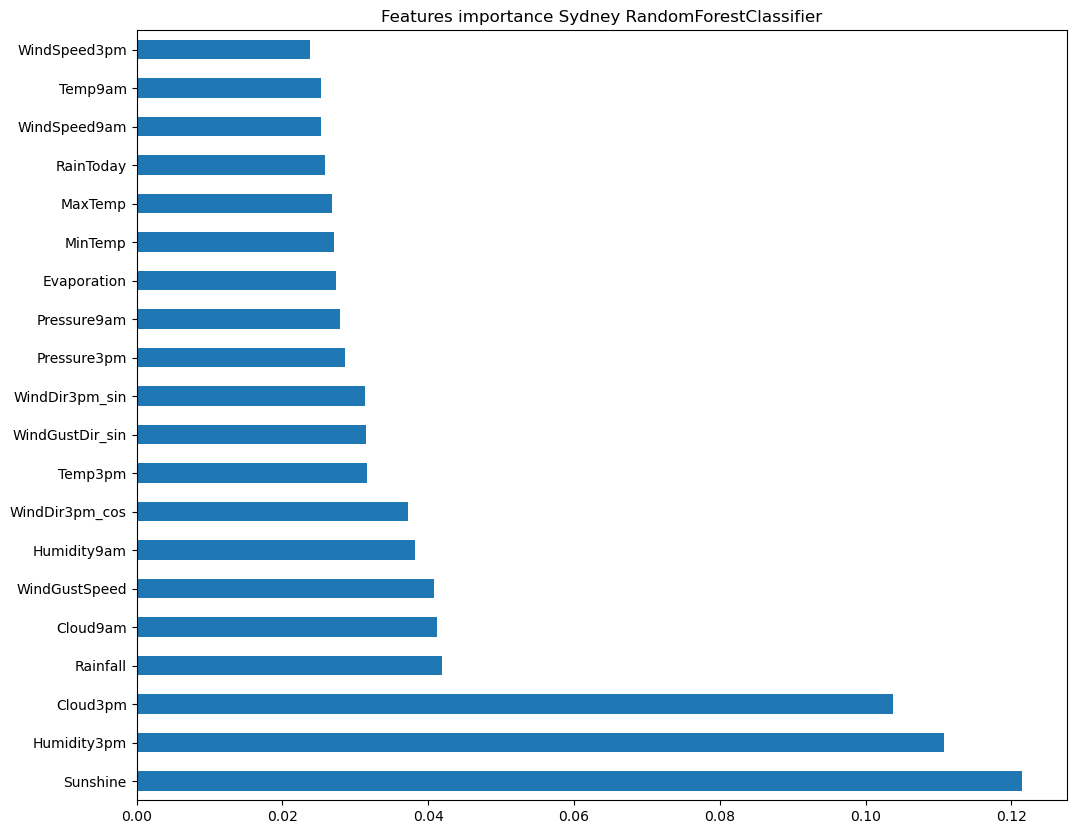

In [33]:
# model par location
select_location = "Sydney"
# df_location = list()

# Choix des modèles (fixe pour l'instant) 
models_select  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1)
}

param_test = {
    'LogisticRegression': {
                           'C': [1], 
                           'solver': ['liblinear']},
    'RandomForestClassifier': {'n_estimators': [10], 
                               'max_depth': [2]},
}

df_location =  pd.read_csv("../src/data_location_V2/df_" + select_location + ".csv", index_col=["id_Location","id_Date"])

modeling_location(select_location, df_location, models_select, param_grids=param_grids1, 
                  resampler = SMOTETomek())



DEBUT DE MODELISATION SUR  Albury
Part des données par années  Date
2008   0.01
2009   0.13
2010   0.25
2011   0.36
2012   0.47
2013   0.58
2014   0.70
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [00:01<00:00, 15.63it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.88,0.76,0.76,0.87,0.03
LinearSVC,0.88,0.76,0.76,0.87,0.02
LinearDiscriminantAnalysis,0.88,0.76,0.76,0.87,0.12
AdaBoostClassifier,0.88,0.75,0.75,0.87,0.18
RidgeClassifier,0.87,0.73,0.73,0.86,0.02
RidgeClassifierCV,0.87,0.73,0.73,0.86,0.14
BaggingClassifier,0.87,0.73,0.73,0.86,0.16
Perceptron,0.85,0.74,0.74,0.85,0.01
PassiveAggressiveClassifier,0.85,0.75,0.75,0.85,0.01


Fitting  LogisticRegression
Fitting  RandomForestClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.88    0.96      0.92   720.00
1.0                0.75    0.50      0.60   182.00
accuracy           0.86    0.86      0.86     0.86
macro avg          0.81    0.73      0.76   902.00
weighted avg       0.86    0.86      0.85   902.00
Matrice de confusion :
      0.00  1.00
0.00   689    31
1.00    91    91


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.97      0.92   720.00
1.0                0.76    0.43      0.55   182.00
accuracy           0.86    0.86      0.86     0.86
macro avg          0.82    0.70      0.73   902.00
weighted avg       0.85    0.86      0.84   902.00
Matrice de confusion :
      0.00  1.00
0.00   696    24
1.00   104    78
Classes échantillon initial : {0.0: 1673, 1.0:

100%|██████████| 26/26 [00:01<00:00, 16.07it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.87,0.76,0.76,0.87,0.02
LogisticRegression,0.87,0.75,0.75,0.86,0.02
LinearDiscriminantAnalysis,0.87,0.75,0.75,0.86,0.09
RidgeClassifierCV,0.87,0.74,0.74,0.86,0.11
RidgeClassifier,0.87,0.74,0.74,0.86,0.03
RandomForestClassifier,0.85,0.73,0.73,0.85,0.32
SGDClassifier,0.85,0.72,0.72,0.84,0.02
CalibratedClassifierCV,0.86,0.69,0.69,0.84,0.05
BaggingClassifier,0.84,0.73,0.73,0.84,0.14


Fitting  LogisticRegression
Fitting  RandomForestClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.93      0.91   711.00
1.0                0.66    0.53      0.58   171.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.77    0.73      0.75   882.00
weighted avg       0.85    0.85      0.85   882.00
Matrice de confusion :
      0.00  1.00
0.00   664    47
1.00    81    90


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.94      0.91   711.00
1.0                0.66    0.51      0.57   171.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.77    0.72      0.74   882.00
weighted avg       0.84    0.85      0.85   882.00
Matrice de confusion :
      0.00  1.00
0.00   666    45
1.00    84    87
Classes échantillon initial : {0.0: 1634, 1.0:

100%|██████████| 26/26 [00:01<00:00, 18.03it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.90,0.69,0.69,0.88,0.02
LinearDiscriminantAnalysis,0.90,0.71,0.71,0.88,0.03
SGDClassifier,0.89,0.70,0.70,0.88,0.02
LogisticRegression,0.90,0.69,0.69,0.88,0.03
RidgeClassifier,0.89,0.66,0.66,0.87,0.02
RidgeClassifierCV,0.89,0.65,0.65,0.87,0.13
RandomForestClassifier,0.89,0.65,0.65,0.86,0.31
Perceptron,0.87,0.70,0.70,0.86,0.01
ExtraTreesClassifier,0.88,0.63,0.63,0.86,0.20


Fitting  LogisticRegression
Fitting  RandomForestClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.99      0.94   761.00
1.0                0.79    0.31      0.45   131.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.84    0.65      0.69   892.00
weighted avg       0.88    0.89      0.87   892.00
Matrice de confusion :
      0.00  1.00
0.00   750    11
1.00    90    41


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.98      0.93   761.00
1.0                0.72    0.26      0.38   131.00
accuracy           0.88    0.88      0.88     0.88
macro avg          0.80    0.62      0.66   892.00
weighted avg       0.86    0.88      0.85   892.00
Matrice de confusion :
      0.00  1.00
0.00   748    13
1.00    97    34
Classes échantillon initial : {0.0: 1841, 1.0:

100%|██████████| 26/26 [00:01<00:00, 14.80it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.66,0.66,0.66,0.67,0.01
LogisticRegression,0.67,0.68,0.68,0.66,0.02
BaggingClassifier,0.66,0.68,0.68,0.66,0.14
RandomForestClassifier,0.66,0.68,0.68,0.66,0.36
AdaBoostClassifier,0.66,0.68,0.68,0.66,0.16
ExtraTreesClassifier,0.66,0.68,0.68,0.66,0.21
LinearSVC,0.65,0.67,0.67,0.65,0.02
BernoulliNB,0.65,0.64,0.64,0.65,0.12
SGDClassifier,0.65,0.67,0.67,0.64,0.02


Fitting  LogisticRegression
Fitting  RandomForestClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.59    0.77      0.67   269.00
1.0                0.76    0.57      0.65   342.00
accuracy           0.66    0.66      0.66     0.66
macro avg          0.67    0.67      0.66   611.00
weighted avg       0.68    0.66      0.66   611.00
Matrice de confusion :
      0.00  1.00
0.00   207    62
1.00   146   196


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.57    0.84      0.68   269.00
1.0                0.80    0.51      0.62   342.00
accuracy           0.65    0.65      0.65     0.65
macro avg          0.69    0.67      0.65   611.00
weighted avg       0.70    0.65      0.65   611.00
Matrice de confusion :
      0.00  1.00
0.00   226    43
1.00   168   174
Classes échantillon initial : {0.0: 1181, 1.0:

100%|██████████| 26/26 [00:01<00:00, 16.04it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.90,0.72,0.72,0.89,0.03
LinearDiscriminantAnalysis,0.90,0.71,0.71,0.89,0.08
LinearSVC,0.90,0.70,0.70,0.88,0.02
AdaBoostClassifier,0.89,0.70,0.70,0.88,0.20
BaggingClassifier,0.89,0.69,0.69,0.88,0.17
RandomForestClassifier,0.89,0.67,0.67,0.87,0.33
Perceptron,0.88,0.67,0.67,0.87,0.01
SGDClassifier,0.88,0.68,0.68,0.86,0.02
NearestCentroid,0.85,0.76,0.76,0.86,0.01


Fitting  LogisticRegression
Fitting  RandomForestClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.90    0.98      0.94   698.00
1.0                0.80    0.35      0.49   123.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.85    0.67      0.71   821.00
weighted avg       0.88    0.89      0.87   821.00
Matrice de confusion :
      0.00  1.00
0.00   687    11
1.00    80    43


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.99      0.94   698.00
1.0                0.80    0.33      0.46   123.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.85    0.66      0.70   821.00
weighted avg       0.88    0.89      0.87   821.00
Matrice de confusion :
      0.00  1.00
0.00   688    10
1.00    83    40
Classes échantillon initial : {0.0: 1762, 1.0:

100%|██████████| 26/26 [00:01<00:00, 14.89it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.79,0.67,0.67,0.77,0.02
LinearDiscriminantAnalysis,0.79,0.66,0.66,0.77,0.14
LinearSVC,0.80,0.66,0.66,0.77,0.02
ExtraTreesClassifier,0.80,0.65,0.65,0.77,0.25
RandomForestClassifier,0.79,0.65,0.65,0.76,0.37
RidgeClassifier,0.79,0.63,0.63,0.76,0.03
GaussianNB,0.76,0.68,0.68,0.75,0.01
RidgeClassifierCV,0.79,0.63,0.63,0.75,0.16
PassiveAggressiveClassifier,0.74,0.69,0.69,0.75,0.01


Fitting  LogisticRegression
Fitting  RandomForestClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.80    0.95      0.87   645.00
1.0                0.70    0.34      0.46   230.00
accuracy           0.79    0.79      0.79     0.79
macro avg          0.75    0.65      0.66   875.00
weighted avg       0.77    0.79      0.76   875.00
Matrice de confusion :
      0.00  1.00
0.00   611    34
1.00   151    79


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.80    0.97      0.87   645.00
1.0                0.77    0.32      0.45   230.00
accuracy           0.80    0.80      0.80     0.80
macro avg          0.78    0.64      0.66   875.00
weighted avg       0.79    0.80      0.76   875.00
Matrice de confusion :
      0.00  1.00
0.00   623    22
1.00   157    73
Classes échantillon initial : {0.0: 1579, 1.0:

KeyboardInterrupt: 

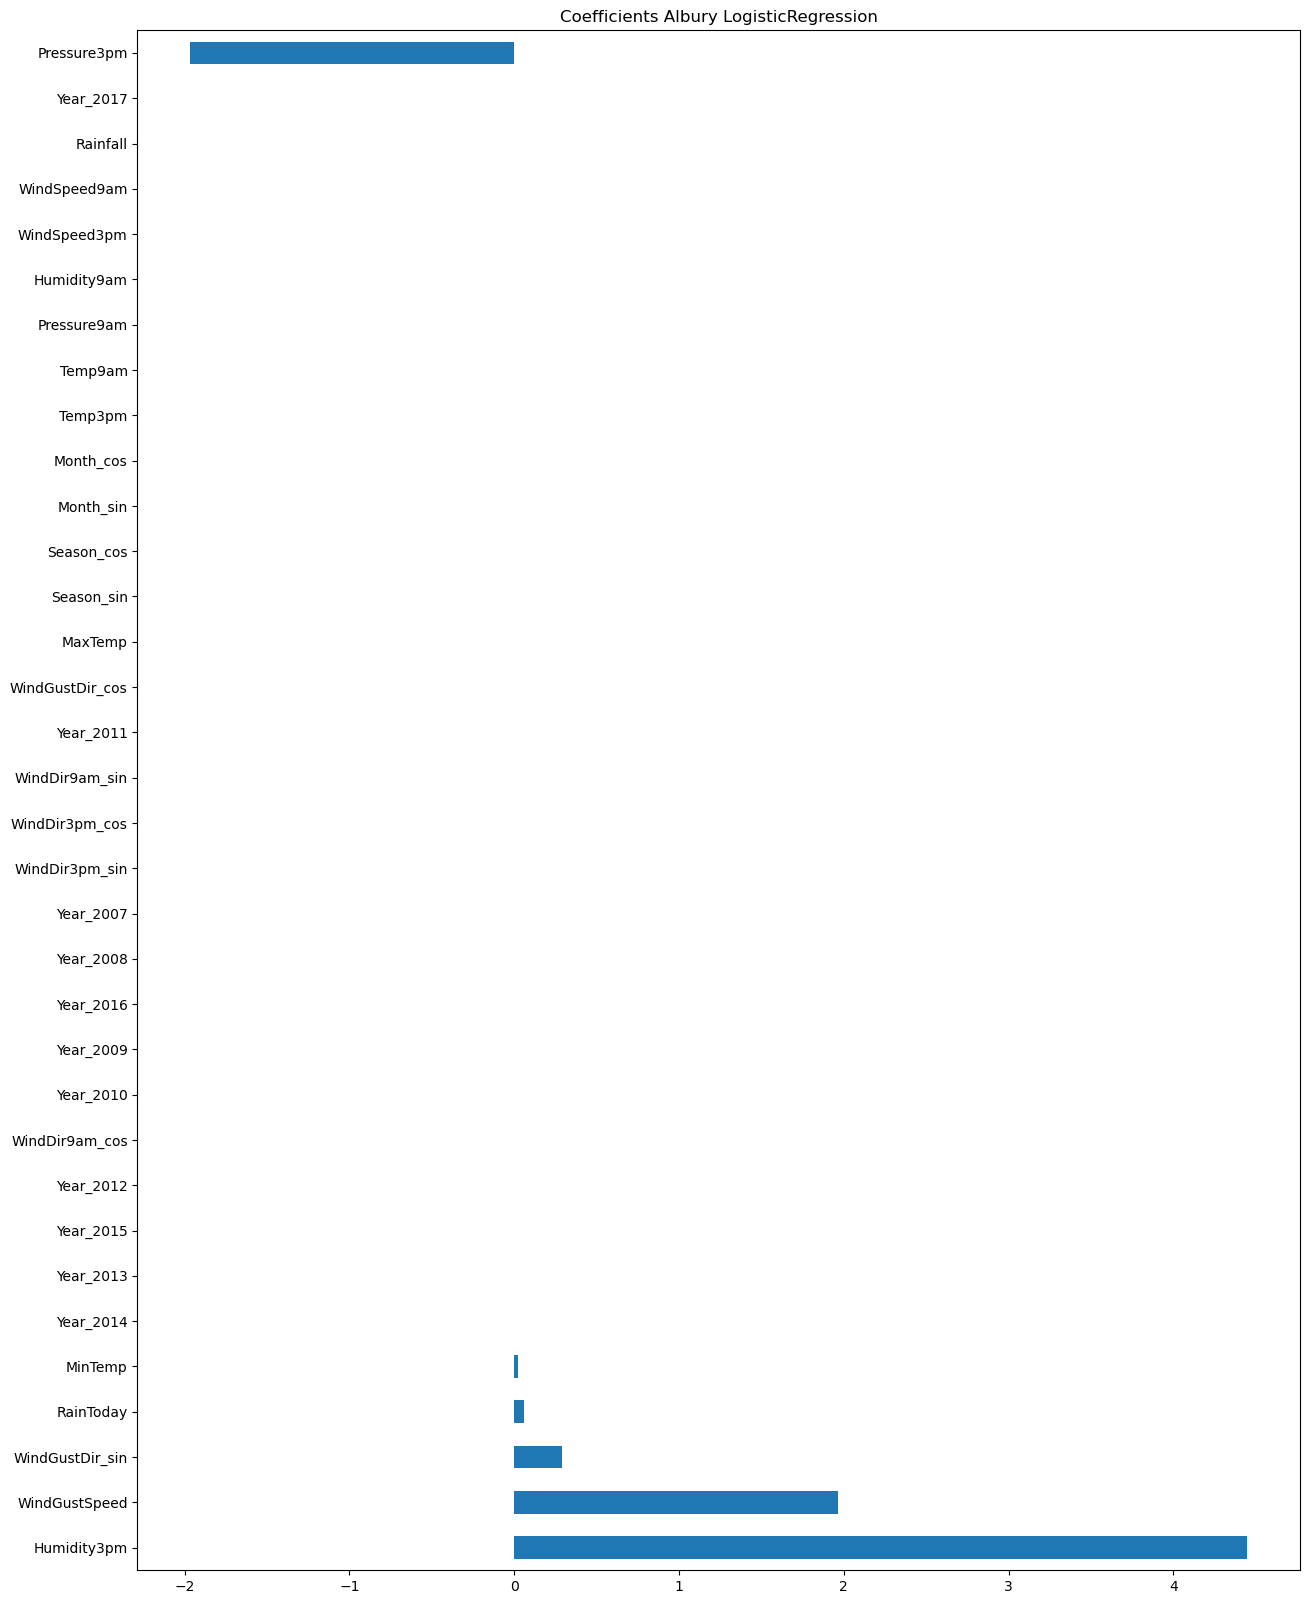

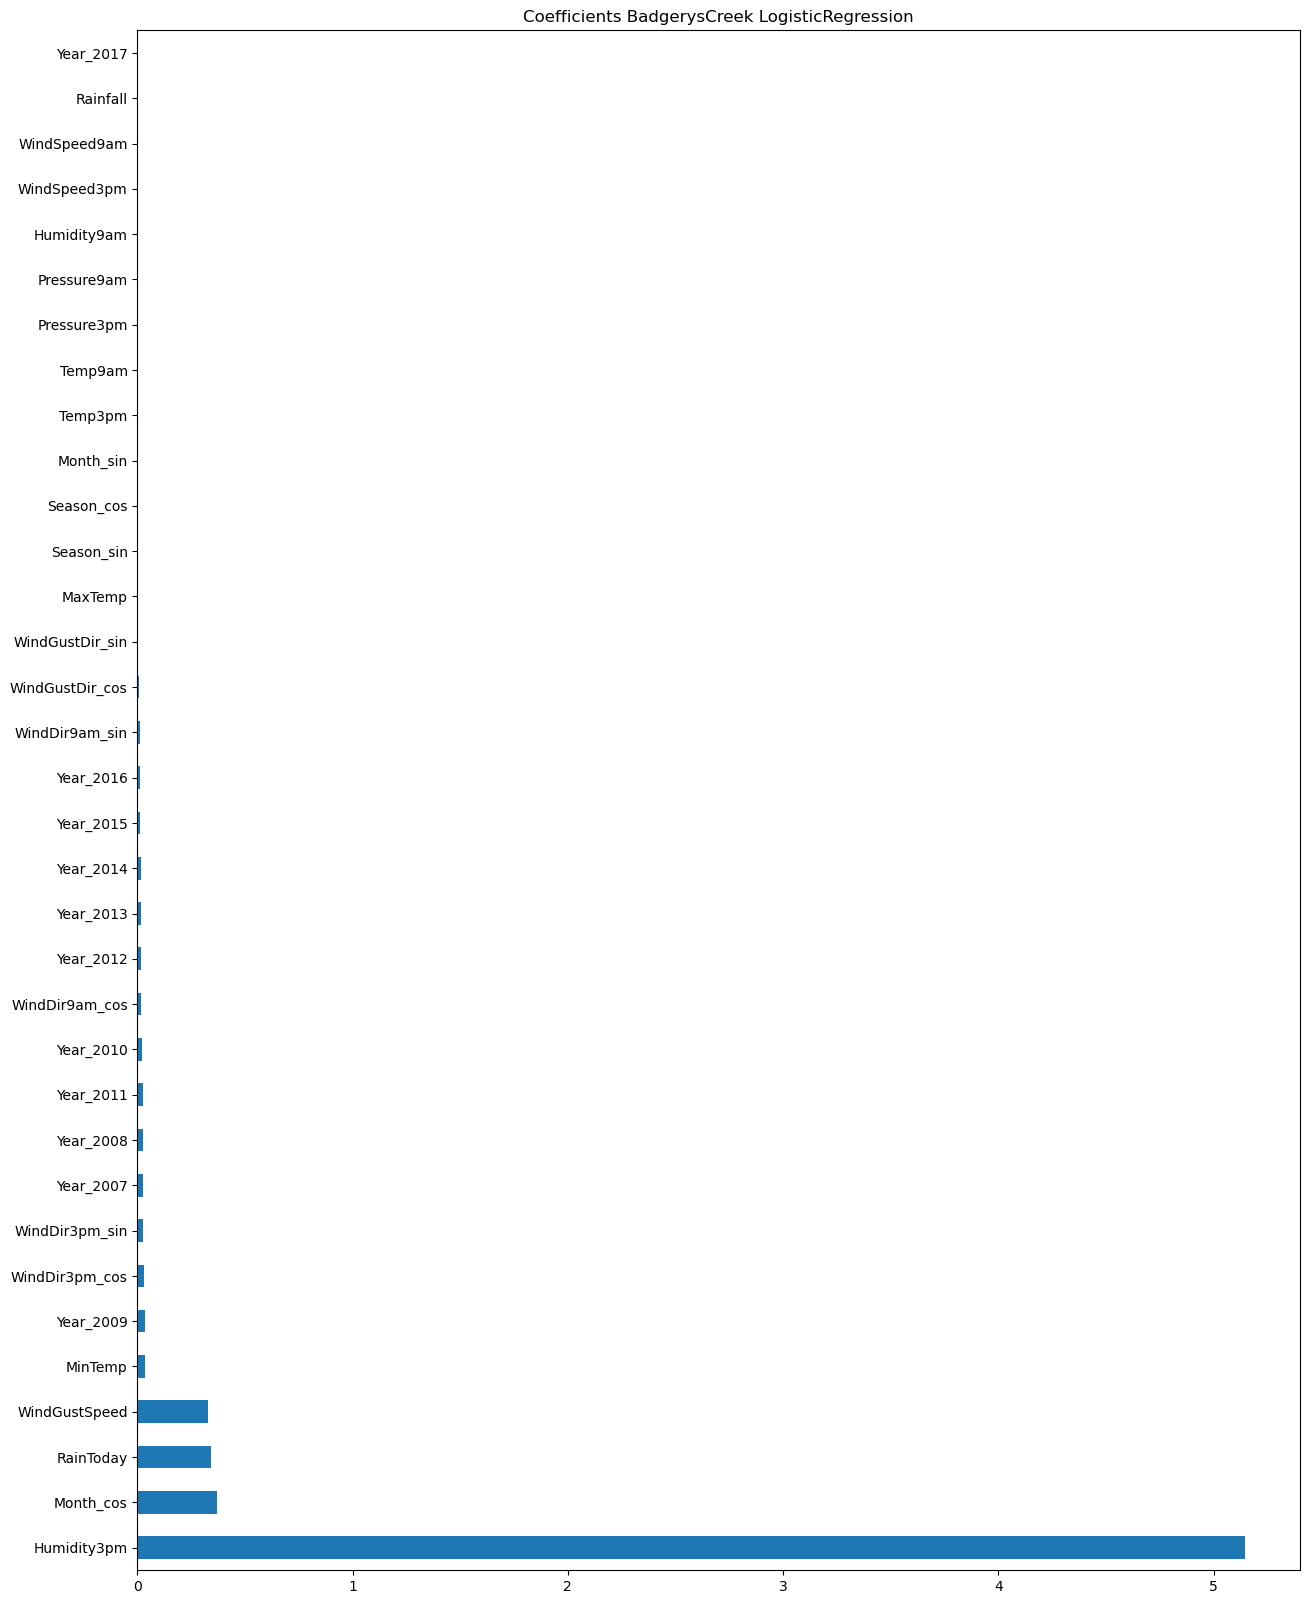

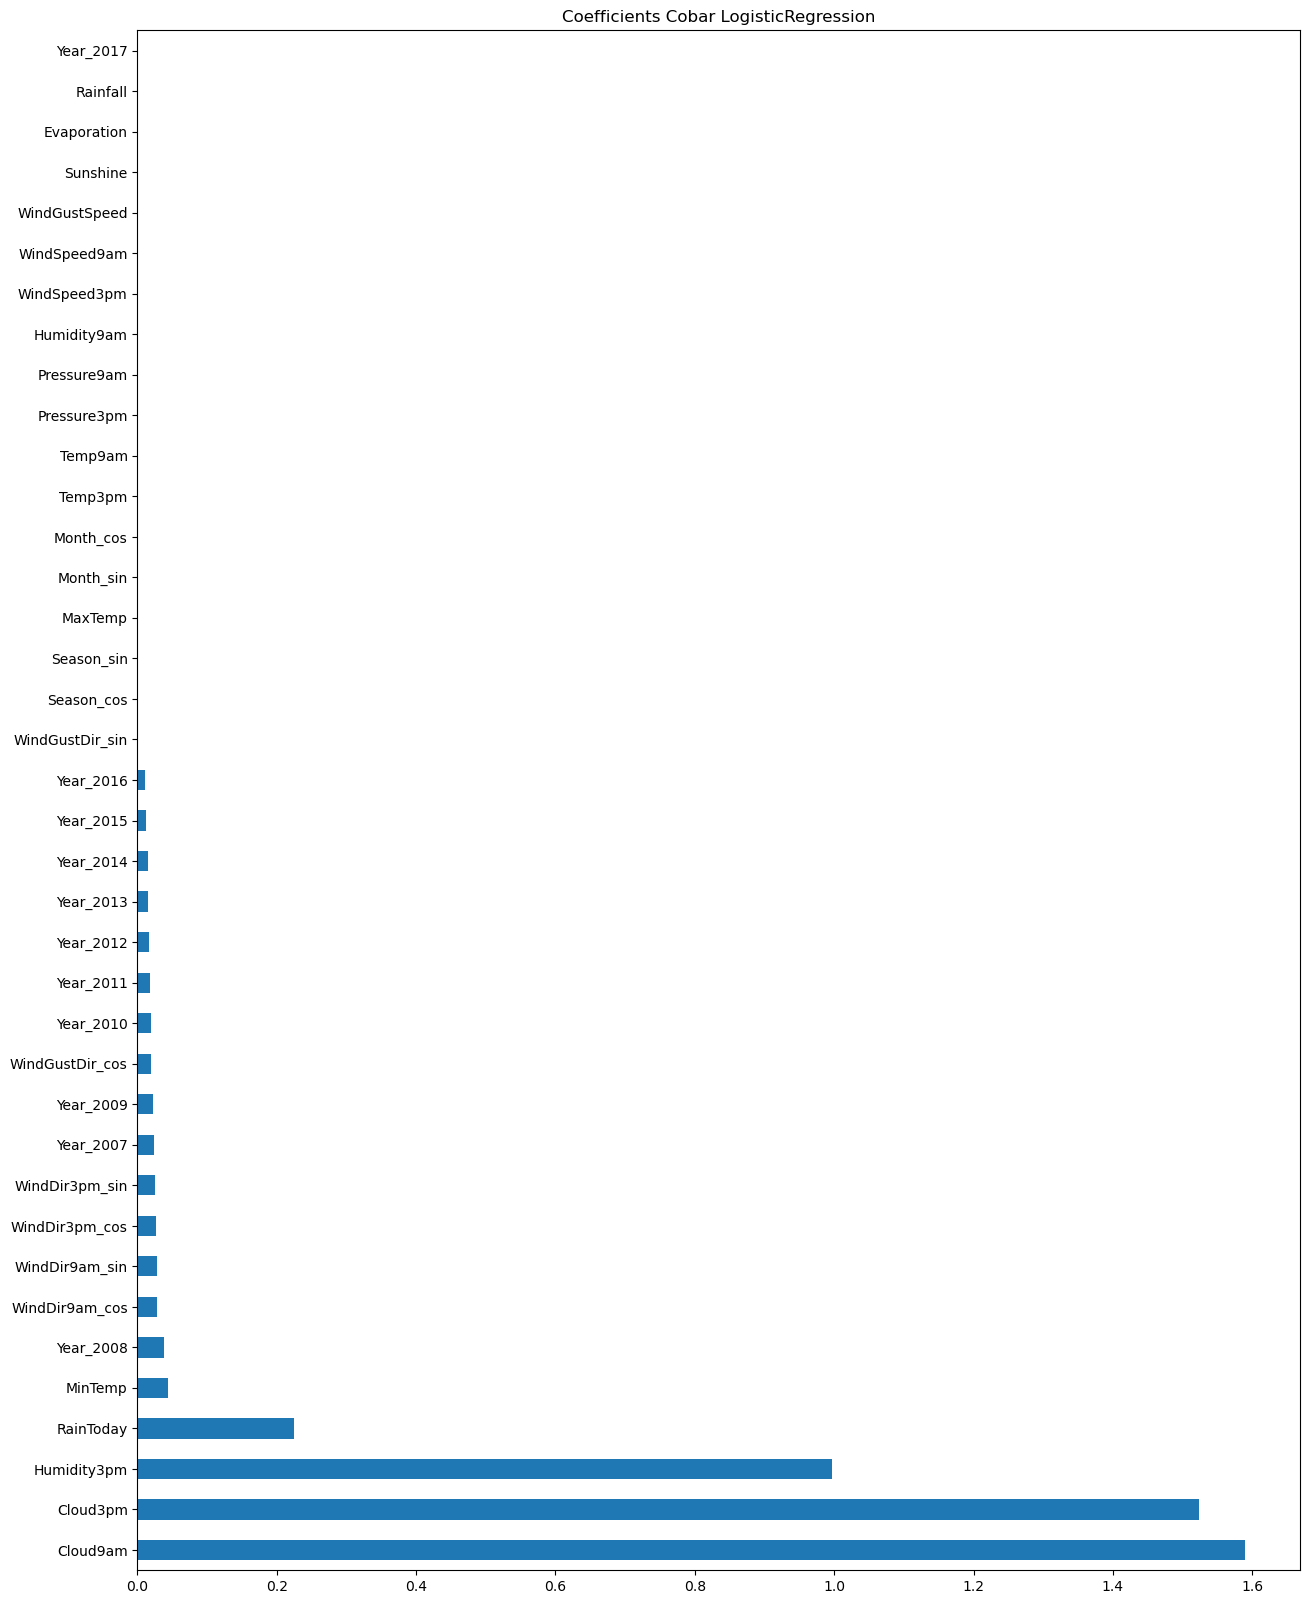

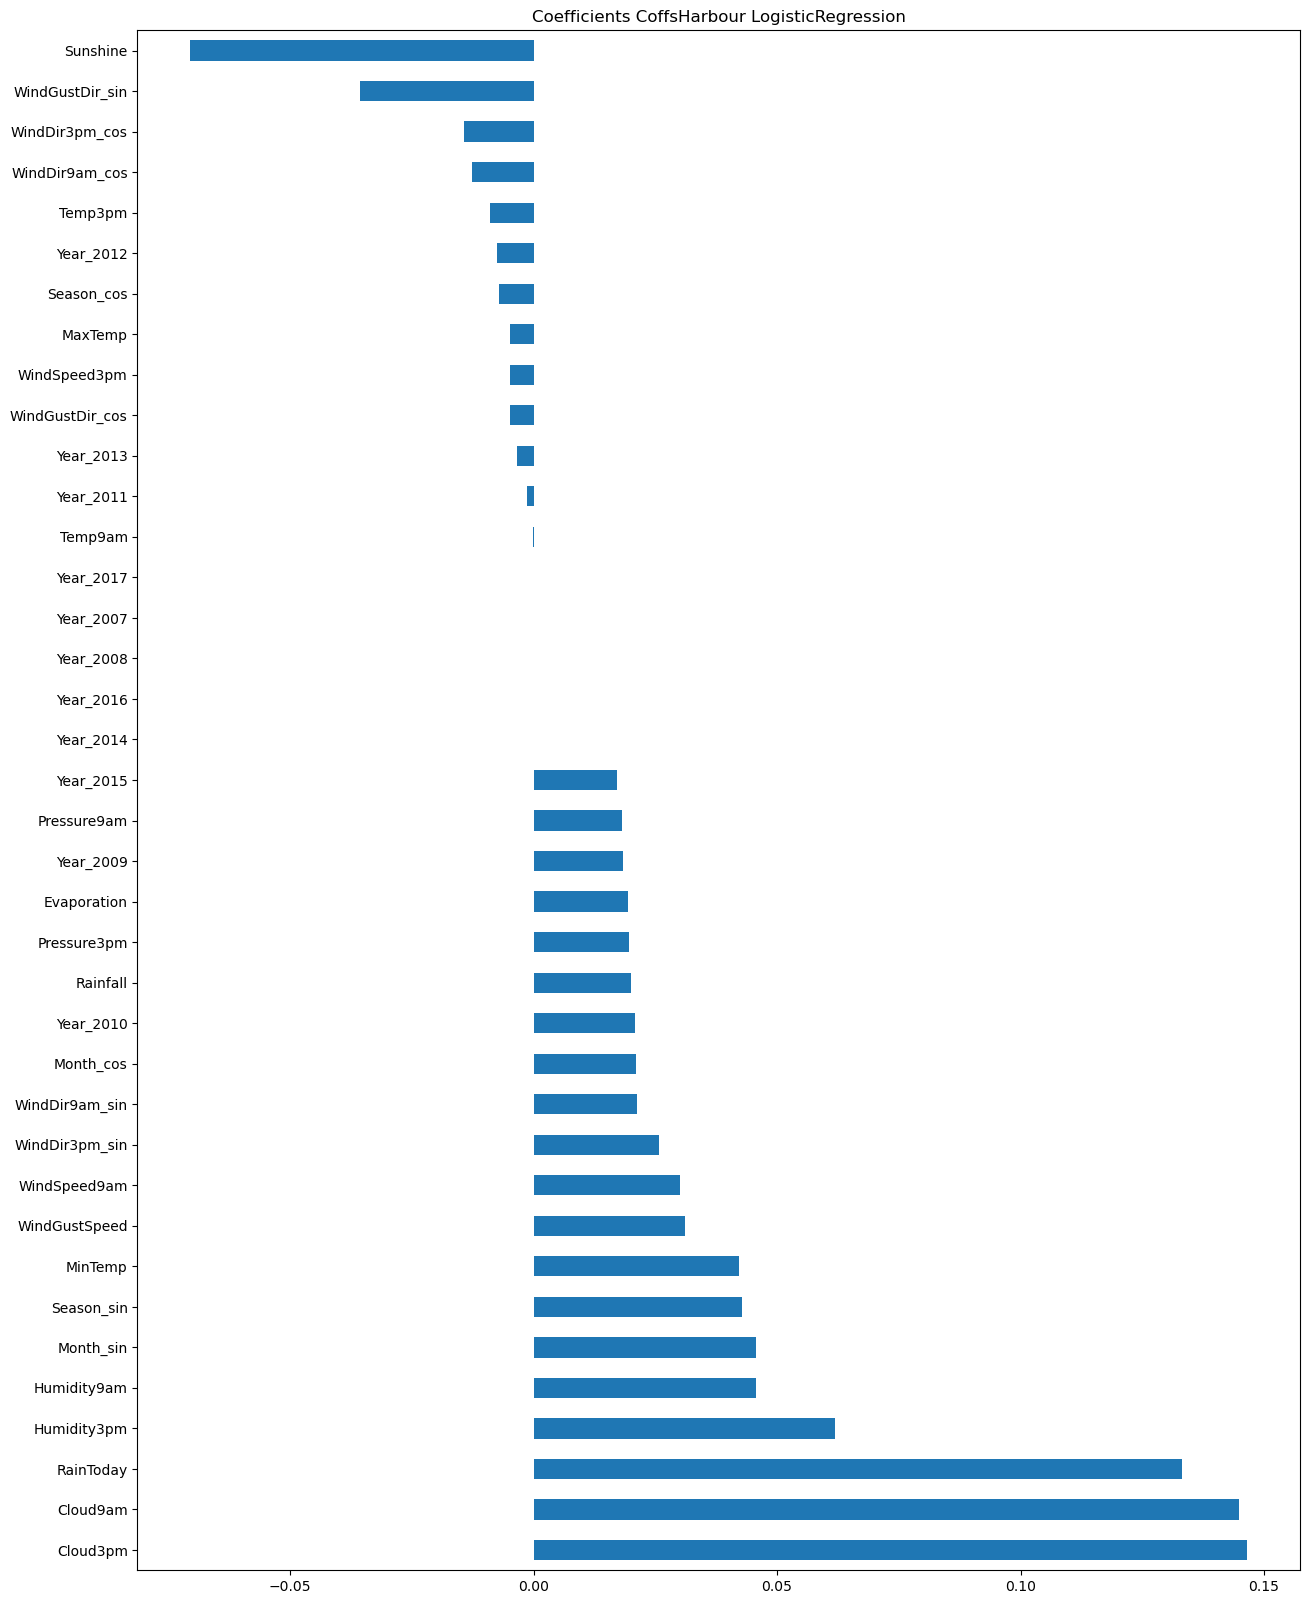

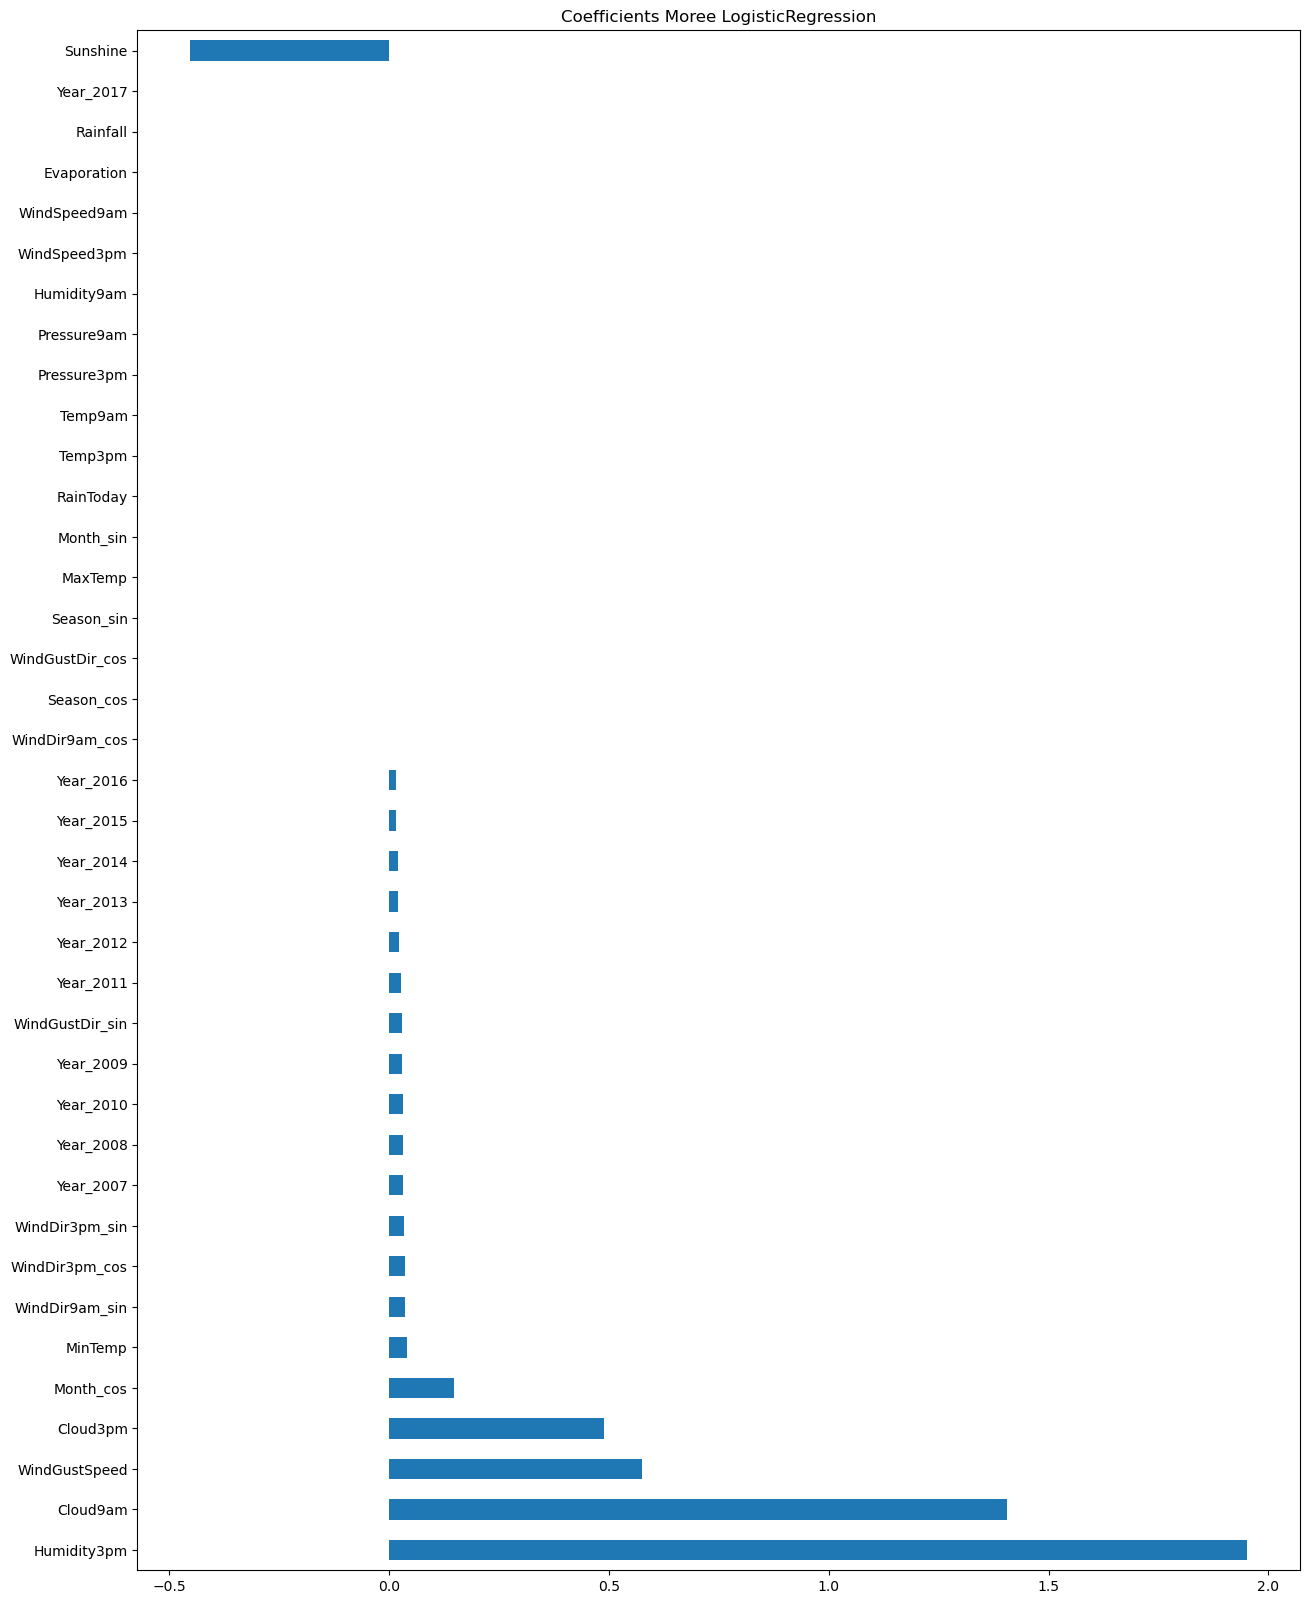

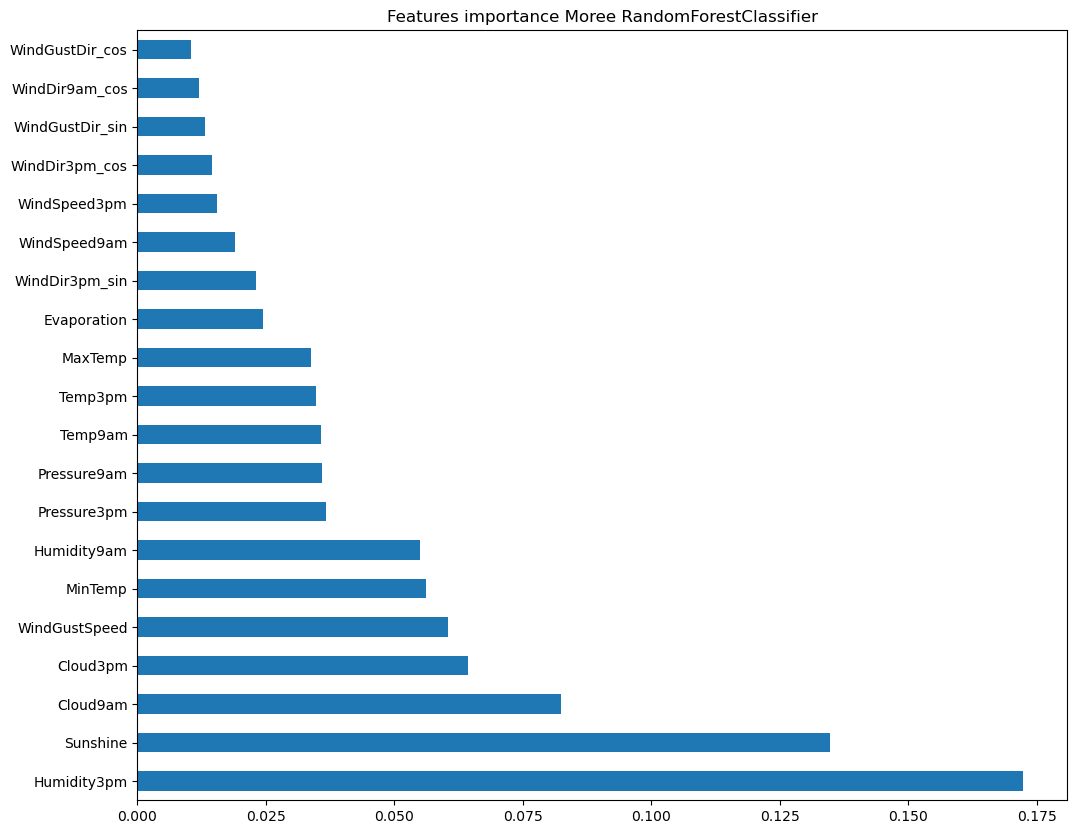

In [451]:
# # Grosse boucle sur toutes les locations, youhou

# location_list = df_V2.Location.unique()

# for select_location in location_list:
#     print("DEBUT DE MODELISATION SUR ", select_location)
#     df_location =  pd.read_csv("../src/data_location_V2/df_" + select_location + ".csv", index_col=["id_Location","id_Date"])
#     modeling_location(select_location, df_location, models_select, param_grids=param_grids2)


In [432]:
print(results_search)

{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 1, 'solver': 'liblinear'}, 'best_cv_score': 0.5788057241576107, 'test_accuracy': 0.7703435804701627, 'test_f1_score': 0.6768447837150128, 'test_precision': 0.6045454545454545, 'test_recall': 0.7687861271676301}}, 'RandomForestClassifier': {'GridSearchCV': {'best_params': {'max_depth': 2, 'n_estimators': 10}, 'best_cv_score': 0.6938980441006509, 'test_accuracy': 0.6907775768535263, 'test_f1_score': 0.6157303370786517, 'test_precision': 0.5036764705882353, 'test_recall': 0.791907514450867}}}


In [2]:
select_location = "Sydney"
# Choix des modèles (fixe pour l'instant) 
models_select  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1)
}

param_test = {
    'LogisticRegression': {
                           'C': [1], 
                           'solver': ['liblinear']},
    'RandomForestClassifier': {'n_estimators': [10], 
                               'max_depth': [2]},
}

df_location =  pd.read_csv("../src/data_location_V2/df_" + select_location + ".csv", 
                           index_col=["id_Location","id_Date"])

modeling_location(select_location, df_location, models_select, param_grids=param_grids2, 
                  resampler=SMOTE())




NameError: name 'LogisticRegression' is not defined